<a href="https://colab.research.google.com/github/mkcyoung/tweet-clustering/blob/main/word2vec_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec/GloVe exploration

In this notebook I use GloVe (https://nlp.stanford.edu/projects/glove) to vectorize tweets and explore relationships between tweets from different authors using dimensionality reduction and various clustering methods.

In [ ]:
# Imports

import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import random

# genism
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# tokenizing sentences
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords

# sklearn stuff
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.cluster import KMeans

# from util import get_sample

%matplotlib inline

## Loading dataset

In [ ]:
# creating sample file and loading it for use

# Uncomment and run to generate csv file with a certain number of randomly selected tweets per author
# tweets_per_author = 1000
# get_sample(tweets_per_author, 'RawTwitterFeeds/AllTweets.csv', 'samples_mike2.csv')

# This functions kills the kernal... may need to figure something else out

# Load csv just created into a pandas dataframe 
# df = pd.read_csv('samples_mike.csv', sep=',',header=0, usecols=[6,7])
# df = pd.read_csv('RawTwitterFeeds/my_sample.csv', sep=',',header=0, usecols=[6,7])
df = pd.read_csv('my_tweets.csv', sep=',',header=0, usecols=[0,1])


In [ ]:
# Separate tweets and authors

tweets = df.values[:,0]
authors = df.values[:,1]



## Loading GloVe model and converting to word2vec with genism

In [ ]:
# Potentially don't even need to train my own model? Maybe a pretrained word2vec model will work fine.

# found a few different pretrained nets
# Google news: https://code.google.com/archive/p/word2vec/
# GloVe trained on tweets!: https://nlp.stanford.edu/projects/glove/

# Seems like genism is good framework to work with this stuff.

# This converts stanford model to word2vec format, doing this for 50,100 and 200d to see which yields best approach
glove_input_file_50 = 'glove.twitter.27B/glove.twitter.27B.50d.txt'
glove_input_file_100 = 'glove.twitter.27B/glove.twitter.27B.100d.txt'
glove_input_file_200 = 'glove.twitter.27B/glove.twitter.27B.200d.txt'

word2vec_output_file_50 = 'glove.27B.50d.txt.word2vec'
word2vec_output_file_100 = 'glove.27B.100d.txt.word2vec'
word2vec_output_file_200 = 'glove.27B.200d.txt.word2vec'

glove2word2vec(glove_input_file_50, word2vec_output_file_50)
glove2word2vec(glove_input_file_100, word2vec_output_file_100)
glove2word2vec(glove_input_file_200, word2vec_output_file_200)

(1193514, 200)

In [ ]:
# Now we load the word2vec model

# load the Stanford GloVe model
filename_50 = 'glove.27B.50d.txt.word2vec'
filename_100 = 'glove.27B.100d.txt.word2vec'
filename_200 = 'glove.27B.200d.txt.word2vec'

model_50 = KeyedVectors.load_word2vec_format(filename_50, binary=False)
model_100 = KeyedVectors.load_word2vec_format(filename_100, binary=False)
model_200 = KeyedVectors.load_word2vec_format(filename_200, binary=False)


In [ ]:
# Now we use the model

# calculate: (king - man) + woman = ?
result_50 = model_50.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
result_100 = model_100.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
result_200 = model_200.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print(result_50)
print(result_100)
print(result_200)

model_200.most_similar(positive=['paris', 'italy'], negative=['france'], topn=1)

[('prince', 0.759779691696167)]
[('queen', 0.7052316069602966)]
[('queen', 0.6820898056030273)]


[('roma', 0.5997512340545654)]

In [ ]:
# Feeding in a word like this returns the word's vector
print(model_50['bat'])

[ 0.78636   0.15768  -0.19367  -0.2055    0.46326   0.50978   0.87492
  0.28752   0.089521  0.97724   0.29743   0.70221  -5.3367   -0.40387
 -0.14685  -0.45728  -0.25447  -0.57568  -0.95175   0.038138 -0.4081
  0.51125   0.53221   0.59966   0.27298  -0.032199  0.10056  -0.093758
 -1.1741   -0.48726  -1.1145    0.66751  -0.26173  -0.15918  -0.46044
  0.4623   -0.53532  -0.14193   0.16007   0.093551 -0.66839   0.24794
  0.26947  -0.51871  -0.32607  -0.18602   0.95514   0.5482   -0.12267
  0.87791 ]


In [ ]:
# model_50.most_similar(positive="money")
# model_100.most_similar(positive="money")
model_200.most_similar(positive="money")

[('cash', 0.8092226386070251),
 ('pay', 0.7433955073356628),
 ('paid', 0.7174028754234314),
 ('dollars', 0.6934535503387451),
 ('get', 0.6916411519050598),
 ('need', 0.6891372799873352),
 ('give', 0.6815212368965149),
 ('spend', 0.6814060211181641),
 ('shit', 0.6787527203559875),
 ('work', 0.6777079701423645)]

## Tokenizing tweets

In [ ]:
# Tokenizing tweets, found a tweet tokenizer! cool: https://www.nltk.org/api/nltk.tokenize.html

print("Original tweet: ",tweets[2])
print("--------------")
print("word_tokenize: ",word_tokenize(tweets[2]))
print("--------------")  
tweetTokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)
twtTokens = tweetTokenizer.tokenize(tweets[2])
print("Tweet Tokenizer: ",twtTokens)

Original tweet:  Three people have begun a return to Earth from space. Watch landing from 8:30amET/12:30 UTC at http://www.nasa.gov/nasatv pic.twitter.com/KeoLbzGEFf
--------------
word_tokenize:  ['Three', 'people', 'have', 'begun', 'a', 'return', 'to', 'Earth', 'from', 'space', '.', 'Watch', 'landing', 'from', '8:30amET/12:30', 'UTC', 'at', 'http', ':', '//www.nasa.gov/nasatv', 'pic.twitter.com/KeoLbzGEFf']
--------------
Tweet Tokenizer:  ['three', 'people', 'have', 'begun', 'a', 'return', 'to', 'earth', 'from', 'space', '.', 'watch', 'landing', 'from', '8:', '30amet', '/', '12:30', 'utc', 'at', 'http://www.nasa.gov/nasatv', 'pic.twitter.com/keolbzgeff']


In [ ]:
# Cleaning tweets further, following: https://machinelearningmastery.com/clean-text-machine-learning-python/

# removes url
nourlTokens = [re.sub(r'^https?:\/\/.*[\r\n]*', '',word) for word in twtTokens]
print("url stripped: ", nourlTokens)
print("-----------------")

# remove punctuation, handles, and hashtags from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in nourlTokens]
print("stripped punction, handles, and hashtags: ", stripped)
print("-----------------")

# remove everything else that isn't alpha
tokens = [word for word in stripped if word.isalpha()]
print("stripped of anything not alphabetical: ",tokens)
print("-----------------")

# filter out stop words
stop_words = set(stopwords.words('english'))
words = [w for w in tokens if not w in stop_words]
print("stripped of stop words: ",words)


url stripped:  ['three', 'people', 'have', 'begun', 'a', 'return', 'to', 'earth', 'from', 'space', '.', 'watch', 'landing', 'from', '8:', '30amet', '/', '12:30', 'utc', 'at', '', 'pic.twitter.com/keolbzgeff']
-----------------
stripped punction, handles, and hashtags:  ['three', 'people', 'have', 'begun', 'a', 'return', 'to', 'earth', 'from', 'space', '', 'watch', 'landing', 'from', '8', '30amet', '', '1230', 'utc', 'at', '', 'pictwittercomkeolbzgeff']
-----------------
stripped of anything not alphabetical:  ['three', 'people', 'have', 'begun', 'a', 'return', 'to', 'earth', 'from', 'space', 'watch', 'landing', 'from', 'utc', 'at', 'pictwittercomkeolbzgeff']
-----------------
stripped of stop words:  ['three', 'people', 'begun', 'return', 'earth', 'space', 'watch', 'landing', 'utc', 'pictwittercomkeolbzgeff']


In [ ]:
# Cleaning function that takes as input tokenized tweet and returns 'cleaned' token tweet array

def tweetCleaner(tokens,verbose=False):
    # removes url
    nourlTokens = [re.sub(r'^https?:\/\/.*[\r\n]*', '',word) for word in tokens]
    
    # remove punctuation, handles, and hashtags from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in nourlTokens]

    # remove everything else that isn't alpha
    alpha_tokens = [word for word in stripped if word.isalpha()]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in alpha_tokens if not w in stop_words]
    
    if verbose == True:
        print("original tokens: ",tokens)
        print("-----------------")
        print("url stripped: ", nourlTokens)
        print("-----------------")
        print("stripped punction, handles, and hashtags: ", stripped)
        print("-----------------")
        print("stripped of anything not alphabetical: ",tokens)
        print("-----------------")
        print("stripped of stop words: ",words)
    
    return words

tweetCleaner(tweetTokenizer.tokenize(tweets[0]),True)
    

original tokens:  ['“', 'goyim', '”', 'not', 'offensive', '?', 'in', 'that', 'case', 'what', 'is', 'offensive', 'is', 'teaching', 'children', 'that', 'what', 'the', 'nazis', 'did', 'is', 'what', '“', 'goyim', '”', 'dohttp', ':/', '/', 'www.independent.co.uk/news/education/education-news/threeyearold-ultraorthodox-jewish-children-told-the-nonjews-are-evil-in-worksheet-produced-by-school-10481682.html', '…']
-----------------
url stripped:  ['“', 'goyim', '”', 'not', 'offensive', '?', 'in', 'that', 'case', 'what', 'is', 'offensive', 'is', 'teaching', 'children', 'that', 'what', 'the', 'nazis', 'did', 'is', 'what', '“', 'goyim', '”', 'dohttp', ':/', '/', 'www.independent.co.uk/news/education/education-news/threeyearold-ultraorthodox-jewish-children-told-the-nonjews-are-evil-in-worksheet-produced-by-school-10481682.html', '…']
-----------------
stripped punction, handles, and hashtags:  ['“', 'goyim', '”', 'not', 'offensive', '', 'in', 'that', 'case', 'what', 'is', 'offensive', 'is', 'teac

['goyim',
 'offensive',
 'case',
 'offensive',
 'teaching',
 'children',
 'nazis',
 'goyim',
 'dohttp']

## Exploring tweet embeddings

In [ ]:
# Ok, how to work on developing tweet embeddings?

# First method will be to simply average all word vectors in a tweet together: 
# https://www.kaggle.com/nitin194/twitter-sentiment-analysis-word2vec-doc2vec

print("Original tweet: ",tweets[0])
raw_tweet = tweetTokenizer.tokenize(tweets[0])
 
clean_tweet = tweetCleaner(raw_tweet,False)

# Create averaged vector

def tweetVector(model,tweet,size):
    tweet_vec = np.zeros(size)#.reshape((1, size))
    count = 0
    # iterate over word in clean tweet, and add to vector, averaging at the end
    for word in tweet:
        try:
            tweet_vec += model[word]
            count += 1
        except KeyError:
#             print(word,"is not a word")
            continue
    if count != 0:
        tweet_vec = tweet_vec / count
    return tweet_vec

tweetVector(model_50,clean_tweet,50)
    

Original tweet:  “Goyim” not offensive? In that case what IS offensive is teaching children that what the nazis did is what “goyim” dohttp://www.independent.co.uk/news/education/education-news/threeyearold-ultraorthodox-jewish-children-told-the-nonjews-are-evil-in-worksheet-produced-by-school-10481682.html …


array([ 0.55053595,  0.32658625,  0.1587725 ,  0.20745175,  0.27613375,
       -0.09718625,  0.16690001,  0.18505874, -0.26592749, -0.44509856,
        0.29302125,  0.104838  , -2.37814751, -0.03346463,  0.42971974,
       -0.07070539,  0.16886876, -0.39250763,  0.53704874,  0.0339257 ,
       -0.27598125,  0.1412425 ,  0.12278626, -0.20609425, -0.3621955 ,
        0.70670875,  0.19792   ,  0.16516226, -0.10564124,  0.34033537,
        0.62011374, -0.02392375,  0.18867625, -0.35186124,  0.2099625 ,
       -0.11214499, -0.53535312, -0.1379675 ,  0.00852175, -0.51206913,
        0.61247373, -0.36332874, -0.10000251,  0.10213826,  0.14607151,
        0.25129749,  0.14404276,  0.327032  , -0.01548625, -0.09597887])

In [ ]:
# Ok, now let's store all tweet's vectors and dim-reduce them to visualize

feature_vecs_50 = []
feature_vecs_100 = []
feature_vecs_200 = []
for i in tweets:
    raw_tweet = tweetTokenizer.tokenize(i)
    clean_tweet = tweetCleaner(raw_tweet,False)
    feature_vecs_50.append(tweetVector(model_50,clean_tweet,50))
    feature_vecs_100.append(tweetVector(model_100,clean_tweet,100))
    feature_vecs_200.append(tweetVector(model_200,clean_tweet,200))
    
print(np.shape(feature_vecs_50))
print(np.shape(feature_vecs_100))
print(np.shape(feature_vecs_200))

(11000, 50)
(11000, 100)
(11000, 200)


In [ ]:
# Dim reduce with t-SNE

X_50 = feature_vecs_50
X_100 = feature_vecs_100
X_200 = feature_vecs_200

tsne_coords_50 = TSNE(n_components=2,perplexity=35,learning_rate=50,metric='euclidean').fit_transform(X_50)
tsne_coords_100 = TSNE(n_components=2,perplexity=35,learning_rate=50,metric='euclidean').fit_transform(X_100)
tsne_coords_200 = TSNE(n_components=2,perplexity=35,learning_rate=50,metric='euclidean').fit_transform(X_200)


In [ ]:
# Using cosine distance instead

tsne_coords_50_cos = TSNE(n_components=2,perplexity=35,learning_rate=50,metric='cosine').fit_transform(X_50)
tsne_coords_100_cos = TSNE(n_components=2,perplexity=35,learning_rate=50,metric='cosine').fit_transform(X_100)
tsne_coords_200_cos = TSNE(n_components=2,perplexity=35,learning_rate=50,metric='cosine').fit_transform(X_200)


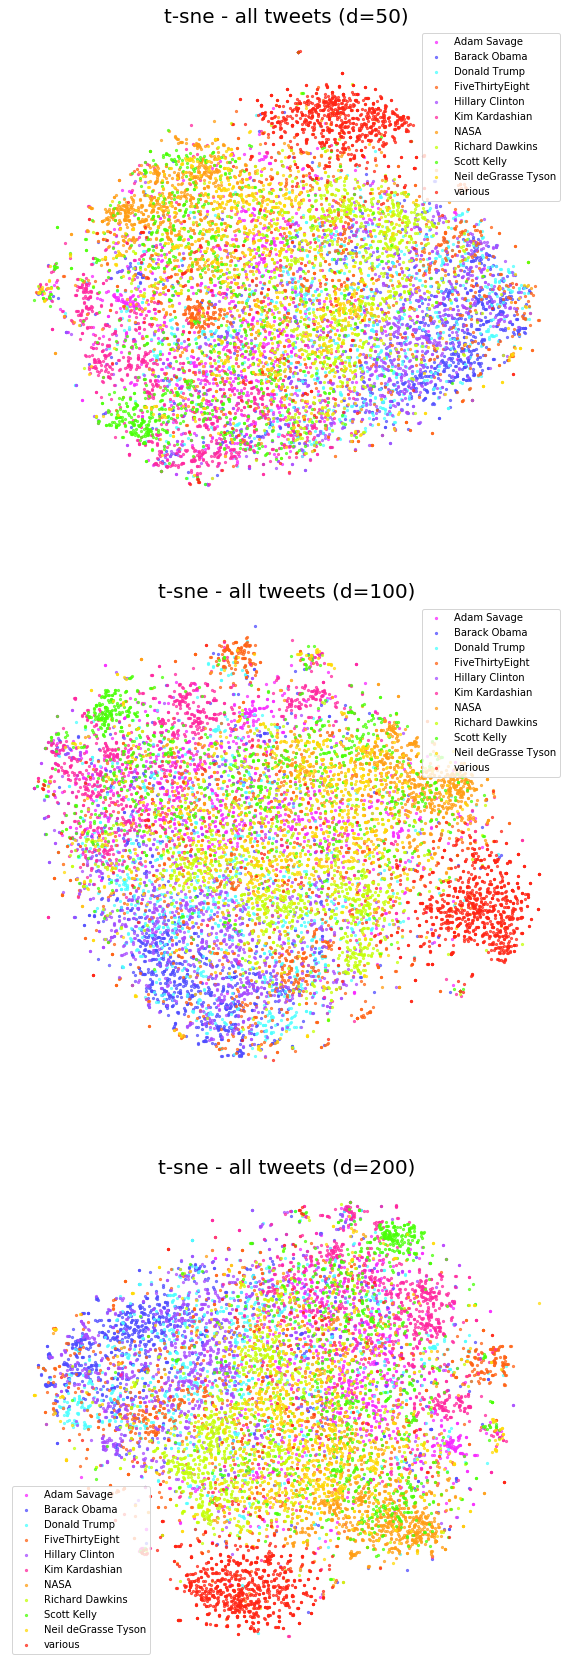

In [ ]:
# Plotting t-SNE results (euclidean)

author_classes = ['Adam Savage','Barack Obama','Donald Trump', \
              'FiveThirtyEight','Hillary Clinton','Kim Kardashian', \
              'NASA','Richard Dawkins', 'Scott Kelly','Neil deGrasse Tyson', \
                 'various']

author_labels = ['AdamSavage','BarackObama','DonaldTrump', \
              'FiveThirtyEight','HillaryClinton','KimKardashian', \
              'NASA','RichardDawkins', 'ScottKelly','deGrasseTyson', \
                 'various']

# Original colors
# colors = ['#DCCCA3','#7dff04','#4A2545','#ff4704','#0501ff','#b116ff','#ff01fb','#D6EADF','#ffd502','#ff024e','#5ADBFF']
colors = ['#f829ff','#504dff','#4dffff','#ff6315','#a94dff','#ff299f','#ff9e15','#c5ff08','#4aff08','#ffda08','#ff2515']

plt.figure(figsize = (10,30))
plt.subplot(3,1,1)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_50[authors==i,0], tsne_coords_50[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - all tweets (d=50)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.subplot(3,1,2)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_100[authors==i,0], tsne_coords_100[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - all tweets (d=100)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.subplot(3,1,3)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_200[authors==i,0], tsne_coords_200[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - all tweets (d=200)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.show()

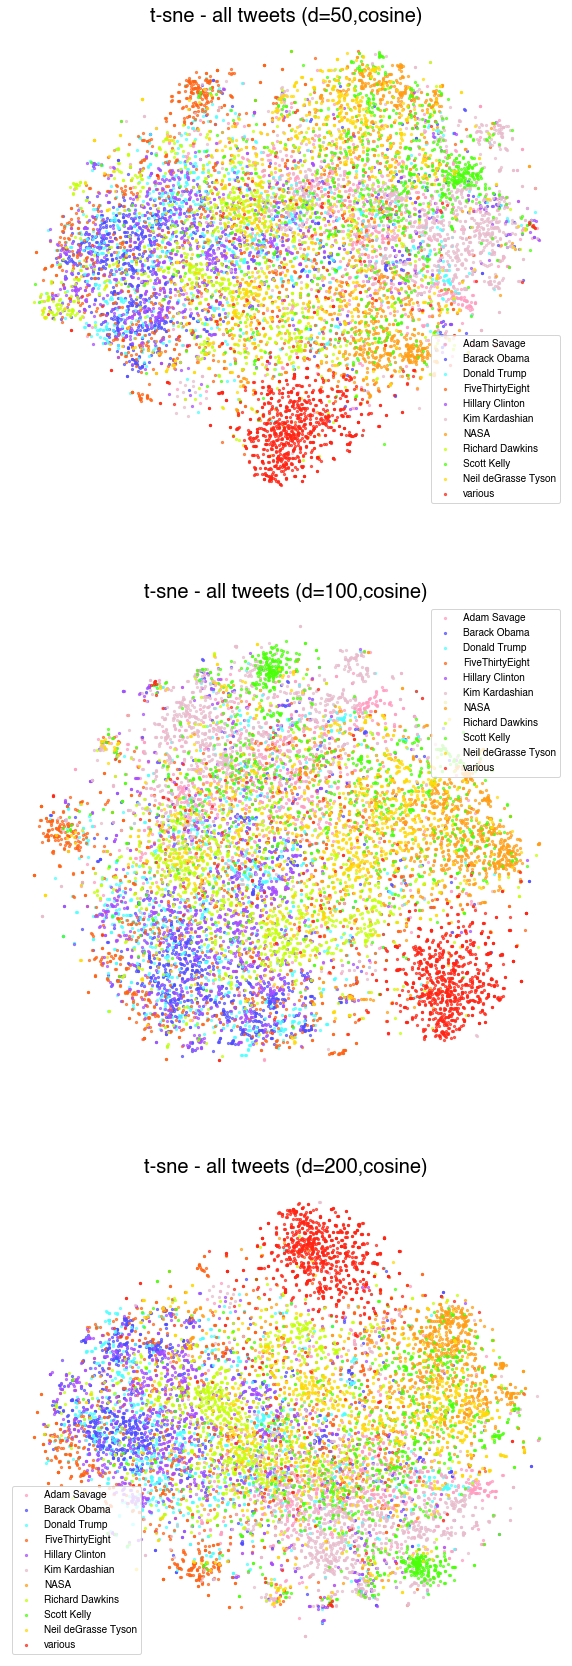

In [ ]:
# Plotting t-SNE results (cosine)

author_classes = ['Adam Savage','Barack Obama','Donald Trump', \
              'FiveThirtyEight','Hillary Clinton','Kim Kardashian', \
              'NASA','Richard Dawkins', 'Scott Kelly','Neil deGrasse Tyson', \
                 'various']

author_labels = ['AdamSavage','BarackObama','DonaldTrump', \
              'FiveThirtyEight','HillaryClinton','KimKardashian', \
              'NASA','RichardDawkins', 'ScottKelly','deGrasseTyson', \
                 'various']

# Original colors
# colors = ['#DCCCA3','#7dff04','#4A2545','#ff4704','#0501ff','#b116ff','#ff01fb','#D6EADF','#ffd502','#ff024e','#5ADBFF']
colors = ['#ff9dc1','#504dff','#4dffff','#ff6315','#a94dff','#e8bdcd','#ff9e15','#c5ff08','#4aff08','#ffda08','#ff2515']

plt.figure(figsize = (10,30))
plt.subplot(3,1,1)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_50_cos[authors==i,0], tsne_coords_50_cos[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - all tweets (d=50,cosine)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.subplot(3,1,2)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_100_cos[authors==i,0], tsne_coords_100_cos[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - all tweets (d=100,cosine)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.subplot(3,1,3)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_200_cos[authors==i,0], tsne_coords_200_cos[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - all tweets (d=200,cosine)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.show()

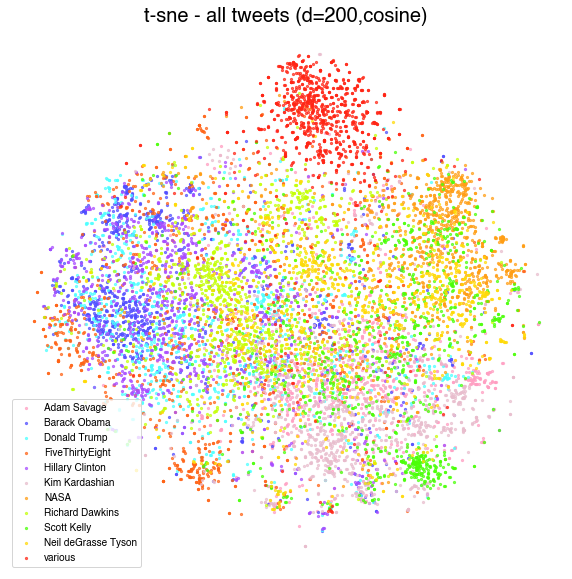

In [ ]:
plt.figure(figsize = (10,10))
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_200_cos[authors==i,0], tsne_coords_200_cos[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - all tweets (d=200,cosine)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.show()

## I think I like cosine more because it looks clumpier and because of that may cluster better....for all my clustering moving forward I'll use the cosine distance. 

In [ ]:
# Let's just see how the political peeps do with t-SNE

# Politcals
df_Obama = pd.read_csv('RawTwitterFeeds/BarackObama.csv', sep=',',header=0, usecols=[5,6])
df_Clinton = pd.read_csv('RawTwitterFeeds/HillaryClintonTweets.csv', sep=',',header=0, usecols=[5,6])
df_DJT = pd.read_csv('RawTwitterFeeds/DonaldTrumpTweets.csv', sep=',',header=0, usecols=[5,6])

# Sample from df frams
num_tweets = 1000
Obama_sampled = df_Obama.sample(n=num_tweets,replace=False,random_state=42)
Clinton_sampled = df_Clinton.sample(n=num_tweets,replace=False,random_state=42)
Trump_sampled = df_DJT.sample(n=num_tweets,replace=False,random_state=42)

# join data frames
df_political = pd.concat([df_Obama,df_Clinton,df_DJT])
df_political_sampled = pd.concat([Obama_sampled,Clinton_sampled,Trump_sampled])

# Separate tweets and authors
politicalTweets = df_political.values[:,0]
politicalAuthors = df_political.values[:,1]

politicalTweets_sampled = df_political_sampled.values[:,0]
politicalAuthors_sampled = df_political_sampled.values[:,1]


# obamaTweets = df_Obama.values[:,0]
# clintonTweets = df_Clinton.values[:,0]
# trumpTweets = df_DJT.values[:,0]


In [ ]:
# Ok, now let's store all tweet's vectors and cluster them 

feature_vecs_political = []
for i in politicalTweets:
    raw_tweet = tweetTokenizer.tokenize(i)
    clean_tweet = tweetCleaner(raw_tweet,False)
    feature_vecs_political.append(tweetVector(clean_tweet,100))
    
print(np.shape(feature_vecs_political))


(27468, 100)


In [ ]:
# Ok, now let's store all tweet's vectors and cluster them - sampled 

feature_vecs_Psampled = []
for i in politicalTweets_sampled:
    raw_tweet = tweetTokenizer.tokenize(i)
    clean_tweet = tweetCleaner(raw_tweet,False)
    feature_vecs_Psampled.append(tweetVector(clean_tweet,100))
    
print(np.shape(feature_vecs_Psampled))

(3000, 100)


In [ ]:
# Dim reduce with t-SNE

# X_political = feature_vecs_political
# tsne_coords_political = TSNE(n_components=2,perplexity=35,learning_rate=50,metric='euclidean').fit_transform(X_political)

X_political = feature_vecs_Psampled
tsne_coords_political = TSNE(n_components=2,perplexity=15,learning_rate=50,metric='euclidean').fit_transform(X_political)




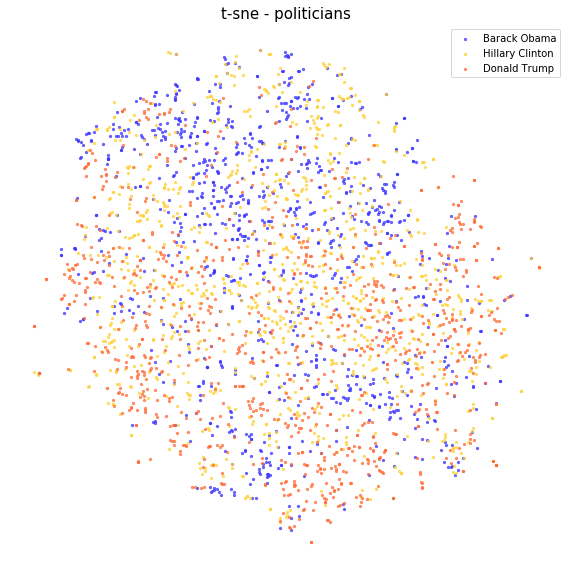

In [ ]:
# Plotting t-SNE results

author_classes = ['Barack Obama','Hillary Clinton','Donald Trump']

author_labels = ['BarackObama','HillaryClinton','DonaldTrump']
colors = ['#3b34ff','#ffd034','#ff6a34']

plt.figure(figsize = (10,10))
# plt.subplot(2,1,1)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(tsne_coords_political[politicalAuthors_sampled==i,0], tsne_coords_political[politicalAuthors_sampled==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('t-sne - politicians',fontsize=15)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]

# plt.subplot(2,1,2)
# for c, i, lab in zip(colorsG, [0, 1, 2, 3, 4, 5, 6, 7], gal_classes):
#     plt.scatter(pca_coordsG[Y==int(i),0], pca_coordsG[Y==int(i),1], alpha=0.7, c=c, label=lab)
# #plt.legend()
# plt.title('pca - galaxies',fontsize=15)
# [i.set_linewidth(0.4) for i in plt.gca().spines.values()]

plt.show()

## Let's cluster, but first PCA and LDA

I'll do PCA down to like ~10 dimensions and then run k-means on that.   
Can also run kmeans and dbscan on tsne plots.   
Once I cluster I'll extract some of the most common words from the cluster.  From here may give me some indication on what kinds of tweets that cluster is composed of. 

In [ ]:
# Helper functions for plotting and the like

      
# single plot
def kMeansPlotSingle(proj_data,clust_data,clusters,n_components,dim_reduct,title=None): 
    km_proj = KMeans(
        n_clusters=clusters, init='k-means++',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )
    km_clust = KMeans(
        n_clusters=clusters, init='k-means++',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )

    y_km = km_proj.fit_predict(proj_data)
    y_km_clust = km_clust.fit_predict(clust_data)

    #print(y_km)
    plt.figure(figsize = (10,10))
#     colors = ['#ff8543','#43b7ff','#c743ff','#ffe343','#50ff2d','#79fff8','#ff0084','#9c7bff'];
    colors = ['#f829ff','#ff299f','#9029ff', '#ffff33', '#a0ff33', '#ffcc33','#22e9ff','#ff6122']
    for i in range(clusters):
        plt.scatter(proj_data[y_km_clust == i, 0],proj_data[y_km_clust == i, 1],c=colors[i],s=2,label=i)
    # Plot the centers
    if n_components == 2 and dim_reduct=='t-SNE':
        plt.plot(km_proj.cluster_centers_[:,0],km_proj.cluster_centers_[:,1],"ok",ms=10)
    if title:
        plt.title(title,fontsize=15)
    else:
        plt.title("K-means with {} clusters on {} ".format(clusters,dim_reduct),fontsize=15)
    plt.axis("off")
    plt.legend()
    [i.set_linewidth(0.4) for i in plt.gca().spines.values()]

    
    plt.show()
      


def clusterOut(data,clusters):
    km_clust = KMeans(
        n_clusters=clusters, init='k-means++',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )


    y_km = km_clust.fit_predict(data)
    return y_km




# Calculate k-means costs
def kmCost(data,n_components,dim_reduct):
    costs_km = []
    for i in range(1, 11):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
        km.fit(data)
        costs_km.append(km.inertia_)

    plt.figure(figsize = (7,5))
    plt.plot(range(1,11),costs_km,'--m',marker='o')
    plt.xlabel("centers")
    plt.ylabel("cost")
    plt.title("k-means elbow on {} with {} components".format(dim_reduct,n_components),fontsize='15')
    plt.show()


In [ ]:
# PCA on 200 element feature vectors

pca_coords_2 = PCA(n_components=2).fit_transform(X_200)
pca_coords_5 = PCA(n_components=5).fit_transform(X_200)
pca_coords_10 = PCA(n_components=10).fit_transform(X_200)
pca_coords_20 = PCA(n_components=20).fit_transform(X_200)


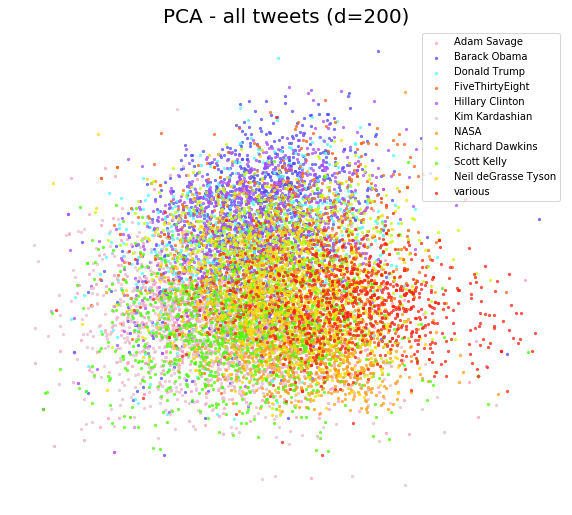

In [ ]:
# plotting PCA results on two dimensions

author_classes = ['Adam Savage','Barack Obama','Donald Trump', \
              'FiveThirtyEight','Hillary Clinton','Kim Kardashian', \
              'NASA','Richard Dawkins', 'Scott Kelly','Neil deGrasse Tyson', \
                 'various']

author_labels = ['AdamSavage','BarackObama','DonaldTrump', \
              'FiveThirtyEight','HillaryClinton','KimKardashian', \
              'NASA','RichardDawkins', 'ScottKelly','deGrasseTyson', \
                 'various']

# Original colors
# colors = ['#DCCCA3','#7dff04','#4A2545','#ff4704','#0501ff','#b116ff','#ff01fb','#D6EADF','#ffd502','#ff024e','#5ADBFF']
colors = ['#ff9dc1','#504dff','#4dffff','#ff6315','#a94dff','#e8bdcd','#ff9e15','#c5ff08','#4aff08','#ffda08','#ff2515']

plt.figure(figsize = (10,30))
plt.subplot(3,1,1)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(pca_coords_2[authors==i,0], pca_coords_2[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('PCA - all tweets (d=200)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]
plt.show()

In [ ]:
# Let's see how LDA looks

LDA_coords_7 = LDA(n_components=7).fit_transform(X_200,authors)


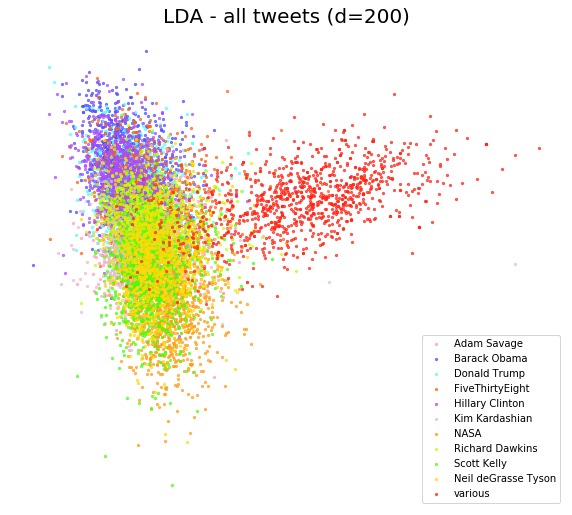

In [ ]:
# plotting LDA results on two dimensions

author_classes = ['Adam Savage','Barack Obama','Donald Trump', \
              'FiveThirtyEight','Hillary Clinton','Kim Kardashian', \
              'NASA','Richard Dawkins', 'Scott Kelly','Neil deGrasse Tyson', \
                 'various']

author_labels = ['AdamSavage','BarackObama','DonaldTrump', \
              'FiveThirtyEight','HillaryClinton','KimKardashian', \
              'NASA','RichardDawkins', 'ScottKelly','deGrasseTyson', \
                 'various']

# Original colors
# colors = ['#DCCCA3','#7dff04','#4A2545','#ff4704','#0501ff','#b116ff','#ff01fb','#D6EADF','#ffd502','#ff024e','#5ADBFF']
colors = ['#ff9dc1','#504dff','#4dffff','#ff6315','#a94dff','#e8bdcd','#ff9e15','#c5ff08','#4aff08','#ffda08','#ff2515']

plt.figure(figsize = (10,30))
plt.subplot(3,1,1)
for c, i, lab in zip(colors, author_labels, author_classes):
#     print(c,i,lab)
    plt.scatter(LDA_coords_7[authors==i,0], LDA_coords_7[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
plt.legend()
plt.title('LDA - all tweets (d=200)',fontsize=20)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]
plt.show()

In [ ]:
# Let's try MDS - nevermind the distance matrix takes wayyyyy too long. 

# # 3 different metrics for dissimilarity matrix:
# # cosine
# cos_dist = pairwise_distances(X_200,metric='cosine')
# # manhattan
# man_dist = pairwise_distances(X_200,metric='manhattan')

# # MDS
# mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=None,
#                    dissimilarity="precomputed")
# cos_mds = mds.fit(cos_dist).embedding_
# man_mds = mds.fit(man_dist).embedding_


# plt.figure(figsize = (10,30))
# plt.subplot(2,1,1)
# for c, i, lab in zip(colors, author_labels, author_classes):
# #     print(c,i,lab)
#     plt.scatter(cos_mds[authors==i,0], cos_mds[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
# plt.legend()
# plt.title('MDS - all tweets (cosine)',fontsize=20)
# plt.xlabel("MDS 1")
# plt.ylabel("MDS 2")
# # plt.axis("off")
# [i.set_linewidth(0.4) for i in plt.gca().spines.values()]


# plt.subplot(2,1,2)
# for c, i, lab in zip(colors, author_labels, author_classes):
# #     print(c,i,lab)
#     plt.scatter(man_mds[authors==i,0], man_mds[authors==i,1], alpha=0.7, c=c, label=lab,s=5)
# plt.legend()
# plt.title('MDS - all tweets (cosine)',fontsize=20)
# plt.xlabel("MDS 1")
# plt.ylabel("MDS 2")
# # plt.axis("off")
# [i.set_linewidth(0.4) for i in plt.gca().spines.values()]
# plt.show()



In [ ]:
# Save pairwise distance matrices....taking 5ever




(11000, 200)

## OK, now lets really start clustering
DBSCAN + k-Means on t-SNE 2  
k-means on PCA with different levels   
k-means on MDS with different levels  


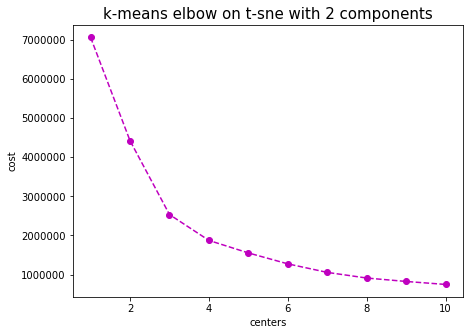

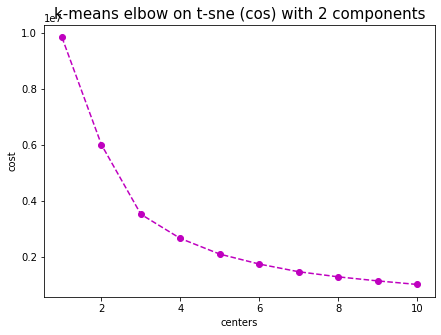

In [ ]:
# Ok so LDA and PCA kind of suck, will stick with t-SNE as how I display clustering results

# Let's do k-means elbow on t-SNE first

kmCost(tsne_coords_200,2,'t-sne')
kmCost(tsne_coords_200_cos,2,'t-sne (cos)')

## from this, it looks like 4, 5, and 6 are good cluster numbers to explore

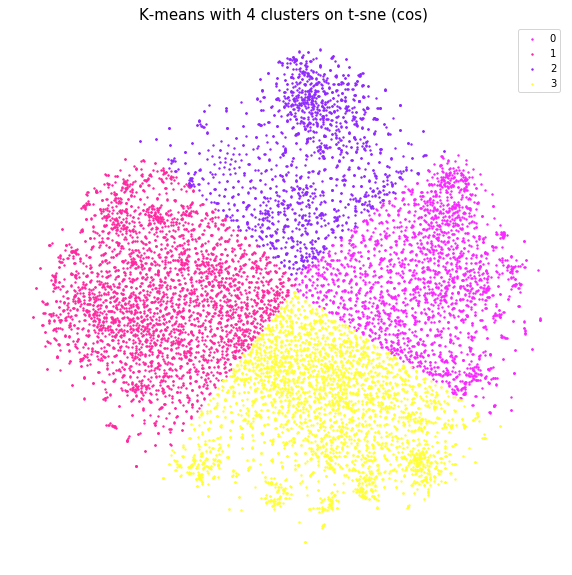

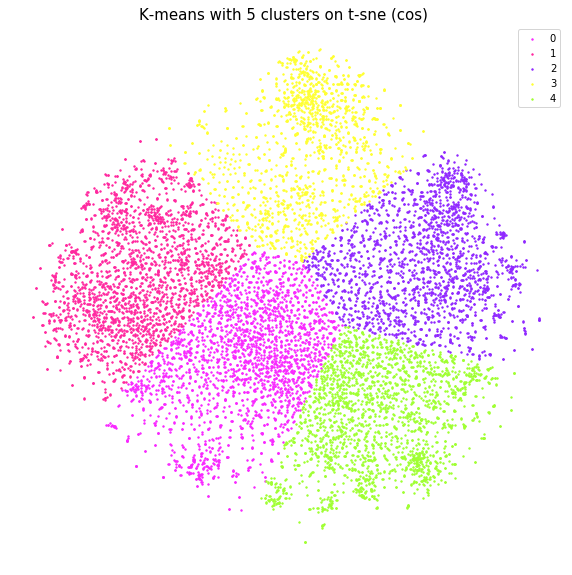

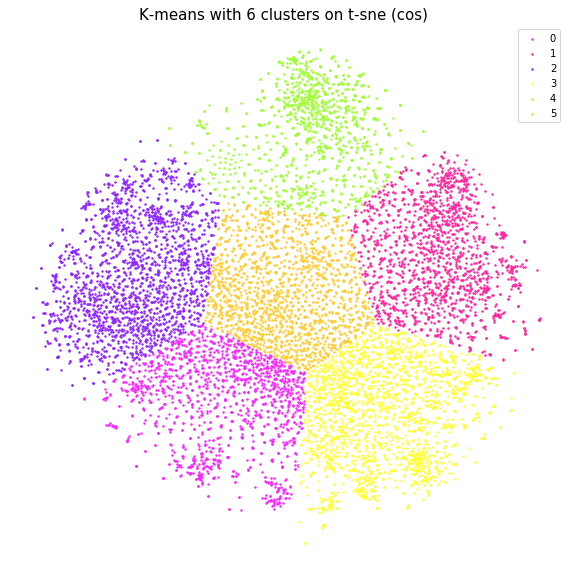

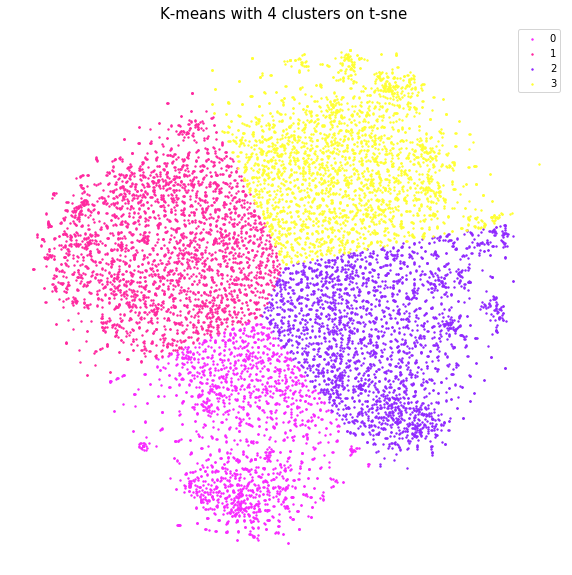

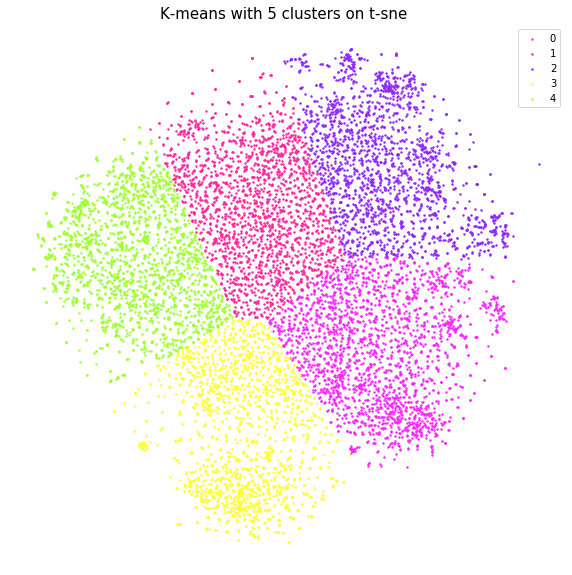

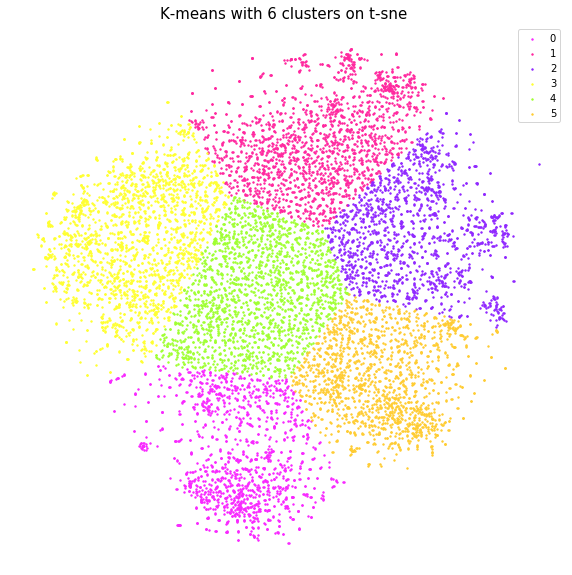

In [ ]:
# Clustering

# def kMeansPlotSingle(proj_data,clust_data,clusters,n_components,dim_reduct,title=None): 
kMeansPlotSingle(tsne_coords_200_cos,tsne_coords_200_cos,4,2,'t-sne (cos)')
kMeansPlotSingle(tsne_coords_200_cos,tsne_coords_200_cos,5,2,'t-sne (cos)')
kMeansPlotSingle(tsne_coords_200_cos,tsne_coords_200_cos,6,2,'t-sne (cos)')

kMeansPlotSingle(tsne_coords_200,tsne_coords_200,4,2,'t-sne')
kMeansPlotSingle(tsne_coords_200,tsne_coords_200,5,2,'t-sne')
kMeansPlotSingle(tsne_coords_200,tsne_coords_200,6,2,'t-sne')

In [ ]:
# save tsne coords and clusterings

tsne_k4_cos = clusterOut(tsne_coords_200_cos,4)
tsne_k5_cos = clusterOut(tsne_coords_200_cos,5)
tsne_k6_cos = clusterOut(tsne_coords_200_cos,6)
tsne_k4 = clusterOut(tsne_coords_200,4)
tsne_k5 = clusterOut(tsne_coords_200,5)
tsne_k6 = clusterOut(tsne_coords_200,6)

# Save as numpy format
np.save('./authors',authors)
np.save('./tsne_coords_cos',tsne_coords_200_cos)
np.save('./tsne_coords',tsne_coords_200)

np.save('./tsne_k4_cos',tsne_k4_cos)
np.save('./tsne_k5_cos',tsne_k5_cos)
np.save('./tsne_k6_cos',tsne_k6_cos)
np.save('./tsne_k4',tsne_k4)
np.save('./tsne_k5',tsne_k5)
np.save('./tsne_k6',tsne_k6)

## DBSCAN with t-SNE

[ 0  0  1 ...  1 -1  0]
number of clusters:  17


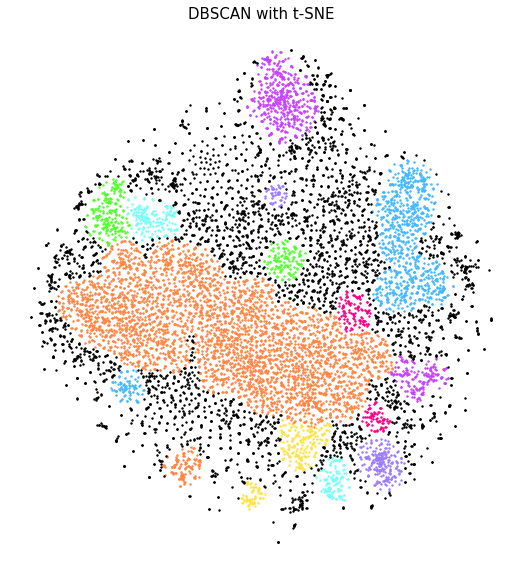

In [ ]:
tsne_db = DBSCAN(eps=2.5,min_samples=50).fit_predict(tsne_coords_200_cos)
# tsne_db = DBSCAN(eps=2.5,min_samples=50).fit_predict(X_tsne_3)
print(tsne_db)
num_clusters = len(np.unique(tsne_db))
print("number of clusters: ",num_clusters)


plt.figure(figsize = (20,10))
colors = ['#ff8543','#43b7ff','#c743ff','#ffe343','#50ff2d','#79fff8','#ff0084','#9c7bff'];
plt.subplot(1,2,1)
for i in range(num_clusters):
    i_color = i % 8
    plt.scatter(tsne_coords_200_cos[tsne_db == i, 0],tsne_coords_200_cos[tsne_db == i, 1],c=colors[i_color],s=2)
plt.scatter(tsne_coords_200_cos[tsne_db == -1, 0],tsne_coords_200_cos[tsne_db == -1, 1],c="black",s=2)
        

plt.title("DBSCAN with t-SNE",fontsize=15)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]
plt.show()
    

In [ ]:
# Save dbscan clustering
np.save('./tsne_db_alt',tsne_db)

# t-sne cluster exporations

In [ ]:
# lets examine the compositions of each cluster to see if our clustering was able to group together anything
# interesting

# Here are metrics of interst - 
# author composition
# top words 
# similar words to top words

# for i in tweets:
#     raw_tweet = tweetTokenizer.tokenize(i)
#     clean_tweet = tweetCleaner(raw_tweet,False)
    

def cluster_metrics(clust_num,clust_data,tweets,authors):
    # Extract only tweets and authors from clust_num
    clust_tweets = tweets[np.where(clust_data==clust_num)]
    # clean the tweets and add words to list
    words = []
    sample_tweets = []
    for i in clust_tweets:
        sample_tweets.append(i)
        raw_tweet = tweetTokenizer.tokenize(i)
        clean_tweet = tweetCleaner(raw_tweet,False)
        for j in clean_tweet:
            words.append(j)
    word_count = np.shape(words)[0]
    # Add words to dictionary, keeping track of count so key: word, value: count
    wordfreq = [words.count(p) for p in words]
    word_dict = dict(list(zip(words,wordfreq)))
    # sort the dict, reutrn as tuple with counts and words
    aux = [(word_dict[key], (word_dict[key]/word_count)*100 , key) for key in word_dict]
    aux.sort()
    aux.reverse()
    
    # Now lets return the author profiles
    author_classes = ['Adam Savage','Barack Obama','Donald Trump', \
              'FiveThirtyEight','Hillary Clinton','Kim Kardashian', \
              'NASA','Richard Dawkins', 'Scott Kelly','Neil deGrasse Tyson', \
                 'various']

    author_labels = ['AdamSavage','BarackObama','DonaldTrump', \
              'FiveThirtyEight','HillaryClinton','KimKardashian', \
              'NASA','RichardDawkins', 'ScottKelly','deGrasseTyson', \
                 'various']
    clust_authors = authors[np.where(clust_data==clust_num)]
    authors_list = list(clust_authors)
    author_count = np.shape(authors_list)[0]
    author_freq = [authors_list.count(p) for p in authors_list]
    author_dict = dict(list(zip(authors_list,author_freq)))
    # sort the dict, reutrn as tuple with counts and words
    aux_auth = [(author_dict[key], (author_dict[key]/author_count)*100 , key) for key in author_dict]
    aux_auth.sort()
    aux_auth.reverse()
        
    
    
    return aux,aux_auth,sample_tweets[:5]
    

def vis_metrics(word_data,author_data,clust_num):
    
    # Show most similar words to top word
    for word in word_data:
        try:
            print("Most similar words to {}: {}".format(word[2],model_200.most_similar(word[2])))
            break
        except KeyError:
            continue
    
    
    word_counts = []
    word_labels = []
    for i in word_data:
        word_counts.append(i[0])
        word_labels.append(i[2])
    author_counts = []
    author_labels = []
    for j in author_data:
        author_counts.append(j[1])
        author_labels.append(j[2])
    
    # Bar chart
    author_ = ['AdamSavage','BarackObama','DonaldTrump', \
              'FiveThirtyEight','HillaryClinton','KimKardashian', \
              'NASA','RichardDawkins', 'ScottKelly','deGrasseTyson', \
                 'various']
    colors = ['#ff9dc1','#504dff','#4dffff','#ff6315','#a94dff','#e8bdcd','#ff9e15','#c5ff08','#4aff08','#ffda08','#ff2515']

    # sort color array for authors
    colors_plot = []
    for i in author_labels:
        colors_plot.append(colors[author_.index(i)])
        
    # color array for words
    colors_clust = ['#f829ff','#ff299f','#9029ff', '#ffff33', '#a0ff33', '#ffcc33','#22e9ff','#ff6122']

    
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.bar(word_labels,word_counts,color=colors_clust[clust_num])
    plt.title('Most frequent words in cluster {}'.format(clust_num),fontsize=20)
    plt.ylabel('word count',fontsize=15)
    plt.xticks(word_labels, fontsize=10, rotation=30)
    plt.xlabel('words',fontsize=15)
    
    plt.subplot(1,2,2)
    plt.bar(author_labels,author_counts,color=colors_plot)
    plt.title('% of author tweets in cluster {}'.format(clust_num),fontsize=20)
    plt.ylabel('tweet percentage (%)',fontsize=15)
    plt.xticks(author_labels, fontsize=10, rotation=30)
    plt.xlabel('authors',fontsize=15)
    
    
    
    plt.show()
        
    

[(231, 1.3039060736057801, 'space'), (201, 1.1345676224881462, 'nasa'), (185, 1.044253781892075, 'earth'), (141, 0.7958907202528789, 'launch'), (131, 0.7394445698803342, 'new'), (119, 0.6717091894332806, 'yearinspacepic'), (113, 0.637841499209754, 'moon'), (112, 0.6321968841724994, 'today'), (102, 0.5757507337999549, 'day'), (101, 0.5701061187627003, 'watch')]
[(793, 44.45067264573991, 'NASA'), (364, 20.40358744394619, 'deGrasseTyson'), (333, 18.66591928251121, 'ScottKelly'), (91, 5.1008968609865475, 'AdamSavage'), (60, 3.3632286995515694, 'FiveThirtyEight'), (40, 2.242152466367713, 'KimKardashian'), (34, 1.905829596412556, 'RichardDawkins'), (25, 1.4013452914798208, 'BarackObama'), (17, 0.952914798206278, 'various'), (15, 0.8408071748878924, 'DonaldTrump'), (12, 0.672645739910314, 'HillaryClinton')]
http://ping.fm/p/SlwTJ - Picture from the Cupola on the ISS. Amazing and useful vantage point. Adjusting well.

This is private / personal
Most similar words to space: [('earth', 0.6140348

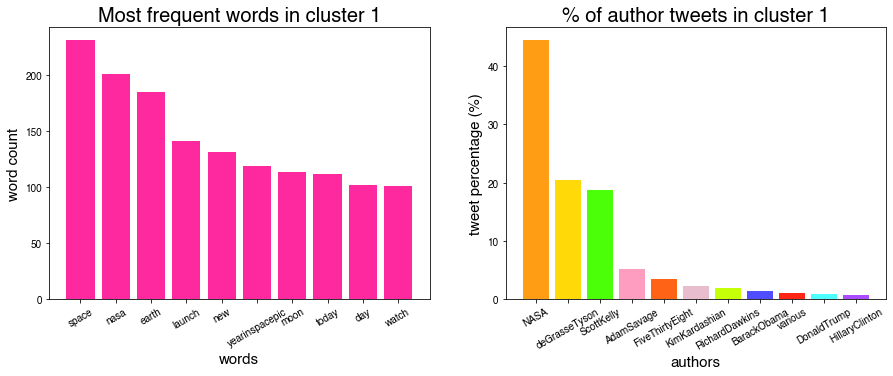

In [ ]:
#### Ok, now have a quick way to recieve info from clusters
clust_words, clust_authors,sample_tweets = cluster_metrics(1,tsne_k6_cos,tweets,authors)
print(clust_words[:10])
print(clust_authors)
print(sample_tweets[1])

vis_metrics(clust_words[:10],clust_authors,1)

## Awesome! Looks to be reasonably good at clustering topics, even with just 2D t-SNE

Looks like Anthony Weiner Is through-most recent poll has him deeply in last place. GOOD NEWS
Most similar words to trump: [('donald', 0.6552975177764893), ('clinton', 0.5108779072761536), ('biden', 0.5093722343444824), ('romney', 0.5069373846054077), ('warren', 0.4898340404033661), ('birther', 0.4887540340423584), ('judd', 0.4777779281139374), ('bloomberg', 0.4759959876537323), ('ivanka', 0.473548024892807), ('reid', 0.4727659225463867)]


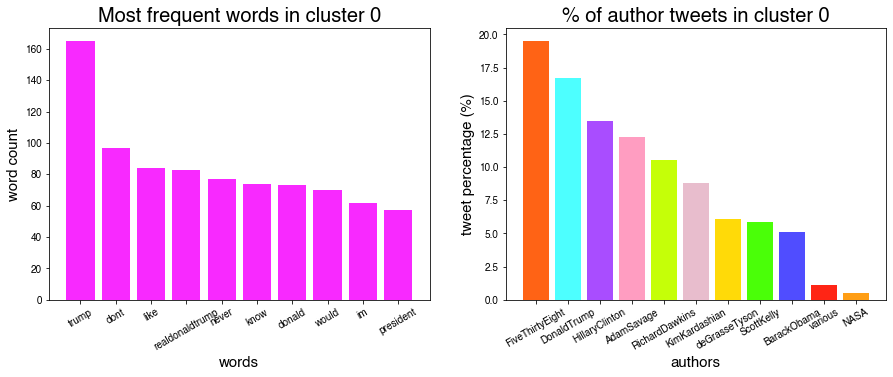

http://ping.fm/p/SlwTJ - Picture from the Cupola on the ISS. Amazing and useful vantage point. Adjusting well.

This is private / personal
Most similar words to space: [('earth', 0.6140348315238953), ('inside', 0.5923542976379395), ('planet', 0.5918987989425659), ('room', 0.5893489122390747), ('the', 0.5725523233413696), ('there', 0.567142128944397), ('into', 0.563407838344574), ('alien', 0.5586540699005127), ('shuttle', 0.5558466911315918), ('view', 0.554189920425415)]


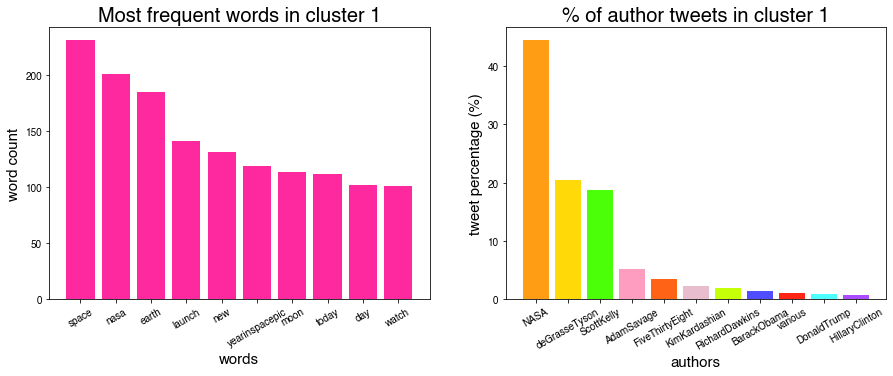

Selective memory - @BarackObama says that he "forgets" the recession http://bit.ly/IYtzM7  Maybe that's why he is forgetting to create jobs.
Most similar words to president: [('obama', 0.792696475982666), ('barack', 0.7790480256080627), ('prez', 0.7003239393234253), ('clinton', 0.6973133087158203), ('government', 0.6662343740463257), ('romney', 0.6630515456199646), ('presidential', 0.6599113941192627), ('potus', 0.6554629802703857), ('pres.', 0.6550410985946655), ('elected', 0.6529227495193481)]


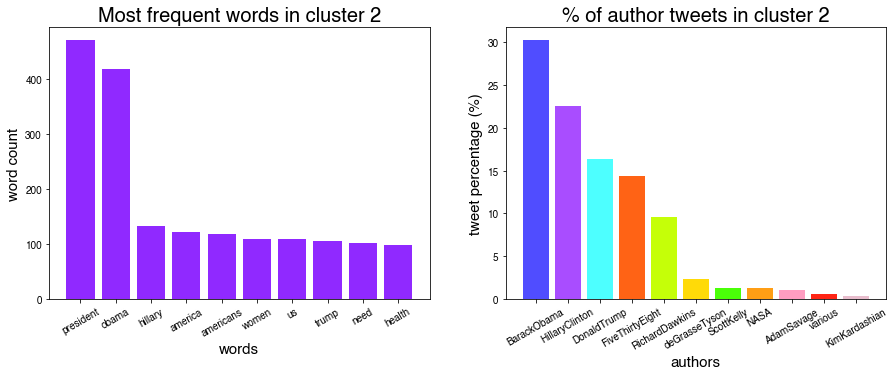

The crowd in Adelaide is fantastic!  One of our stage volunteers said we inspired a 24hour farting competition among her family!
Most similar words to day: [('today', 0.8191546201705933), ('days', 0.8076238632202148), ('happy', 0.8070886135101318), ('morning', 0.7891743779182434), ('night', 0.7859731316566467), ('good', 0.7857174873352051), ('year', 0.7836430072784424), ('week', 0.7735313773155212), ('great', 0.7691963911056519), ('time', 0.766711413860321)]


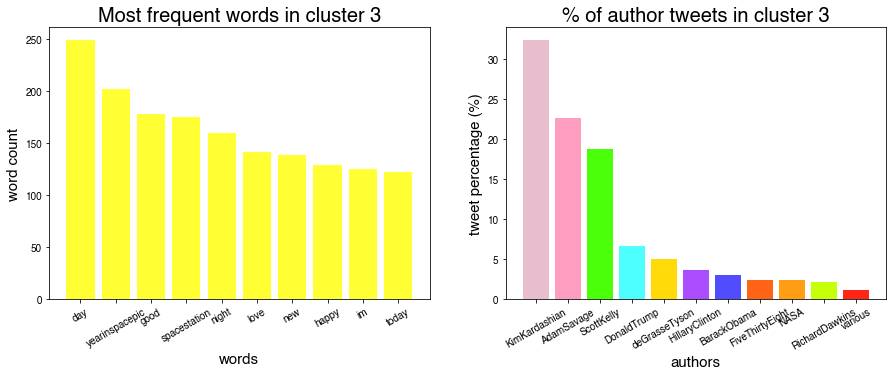

The KDnuggets Coffee Break is out! http://paper.li/Chuck_Moeller/1447794833?edition_id=b54e7510-e761-11e5-a16d-0cc47a0d15fd … Stories via @ashis_samal @TechnoFails @chezou
Most similar words to via: [('<url>', 0.7011606097221375), ('vía', 0.6613482236862183), ('blog', 0.6338077783584595), ('|', 0.6313736438751221), ('by', 0.6141097545623779), ('news', 0.6133575439453125), ('video', 0.5988732576370239), ('youtube', 0.5907558798789978), ('post', 0.5865345597267151), ('check', 0.584824800491333)]


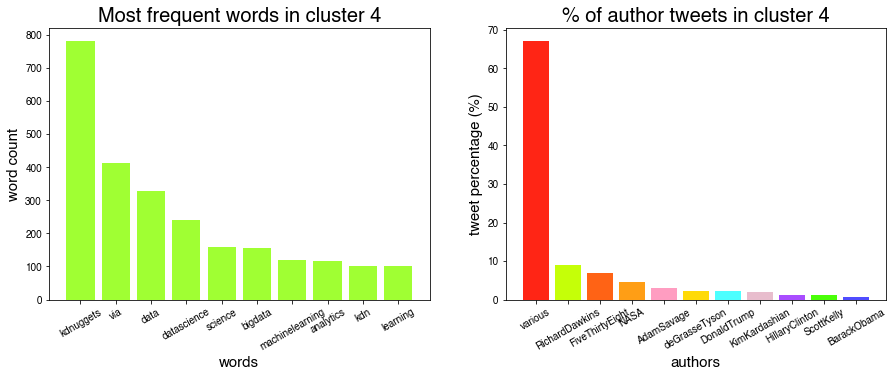

Finally getting around to writing that screenplay? We're here to help: http://53eig.ht/1HAb0ux pic.twitter.com/eswvmBywO3
Most similar words to people: [('ppl', 0.8408032059669495), ('other', 0.827694833278656), ('when', 0.8214244246482849), ('they', 0.8209879994392395), ("n't", 0.8185396790504456), ('many', 0.817920446395874), ('think', 0.8060885667800903), ('them', 0.8057222366333008), ('everyone', 0.8016465306282043), ('know', 0.8015024662017822)]


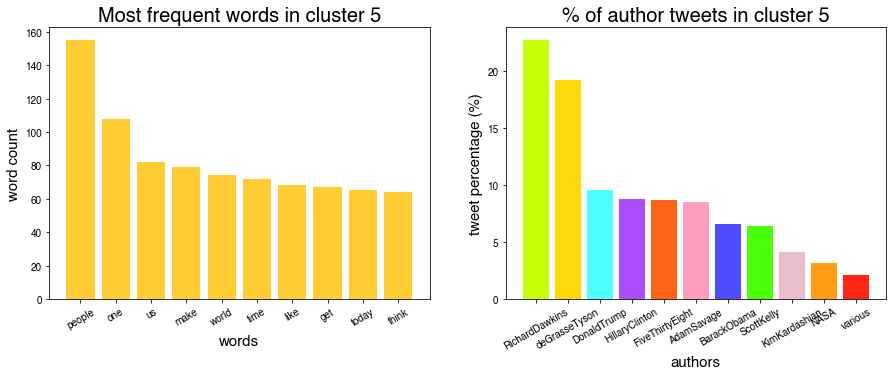

In [ ]:
# Let's do this for all 6 clusters

for i in range(6):
    clust_words, clust_authors,sample_tweets = cluster_metrics(i,tsne_k6_cos,tweets,authors)
#     print(clust_words[:10])
#     print(clust_authors)
    print(sample_tweets[1])
    vis_metrics(clust_words[:10],clust_authors,i)

“Goyim” not offensive? In that case what IS offensive is teaching children that what the nazis did is what “goyim” dohttp://www.independent.co.uk/news/education/education-news/threeyearold-ultraorthodox-jewish-children-told-the-nonjews-are-evil-in-worksheet-produced-by-school-10481682.html …
Most similar words to president: [('obama', 0.792696475982666), ('barack', 0.7790480256080627), ('prez', 0.7003239393234253), ('clinton', 0.6973133087158203), ('government', 0.6662343740463257), ('romney', 0.6630515456199646), ('presidential', 0.6599113941192627), ('potus', 0.6554629802703857), ('pres.', 0.6550410985946655), ('elected', 0.6529227495193481)]


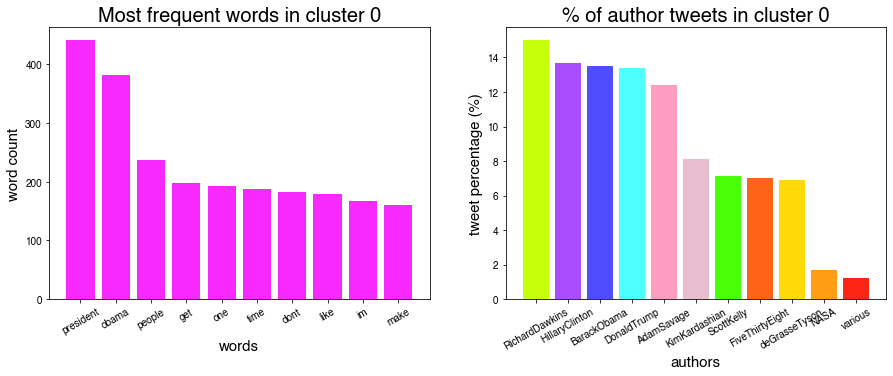

Three people have begun a return to Earth from space. Watch landing from 8:30amET/12:30 UTC at http://www.nasa.gov/nasatv pic.twitter.com/KeoLbzGEFf
Most similar words to space: [('earth', 0.6140348315238953), ('inside', 0.5923542976379395), ('planet', 0.5918987989425659), ('room', 0.5893489122390747), ('the', 0.5725523233413696), ('there', 0.567142128944397), ('into', 0.563407838344574), ('alien', 0.5586540699005127), ('shuttle', 0.5558466911315918), ('view', 0.554189920425415)]


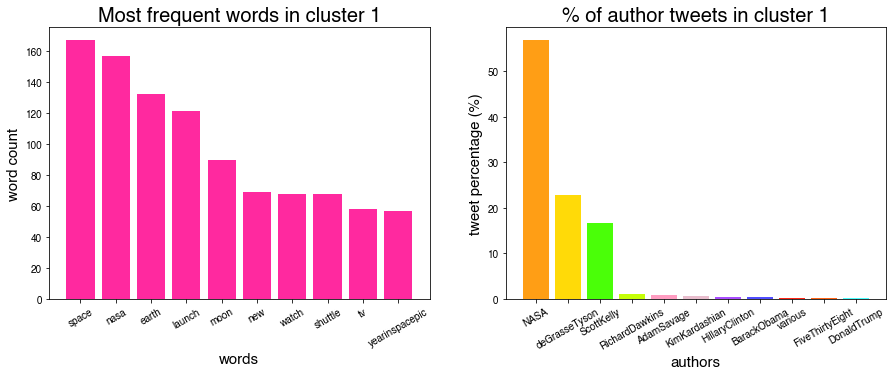

Overview of #Python Visualization Tools #KDN http://ow.ly/YX5xy  via @KDnuggets
Most similar words to data: [('information', 0.6158186793327332), ('report', 0.6043370962142944), ('software', 0.5936977863311768), ('mobile', 0.5883008241653442), ('survey', 0.5800501108169556), ('research', 0.5758471488952637), ('analytics', 0.5748345851898193), ('media', 0.5727987289428711), ('file', 0.5686593055725098), ('email', 0.566149115562439)]


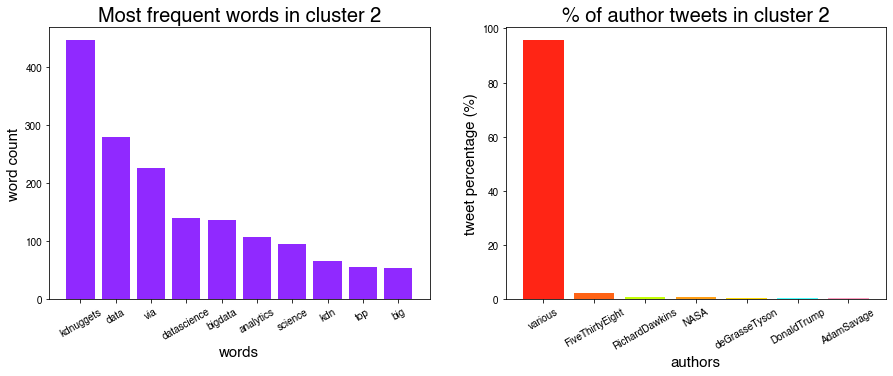

#flashbackfriday @mslaurenlondon @kerihilson me @cassiesuper @foreverkhadijah @forevermalika  u girls! http://instagr.am/p/OK3_8COS4q/ 
Most similar words to love: [('you', 0.8460860848426819), ('much', 0.7890046834945679), ('always', 0.7601684927940369), ('know', 0.75980544090271), ('my', 0.7519949674606323), ('and', 0.7513090372085571), ('loves', 0.7512385845184326), ('life', 0.7443932890892029), ('it', 0.7426839470863342), ("n't", 0.7408117055892944)]


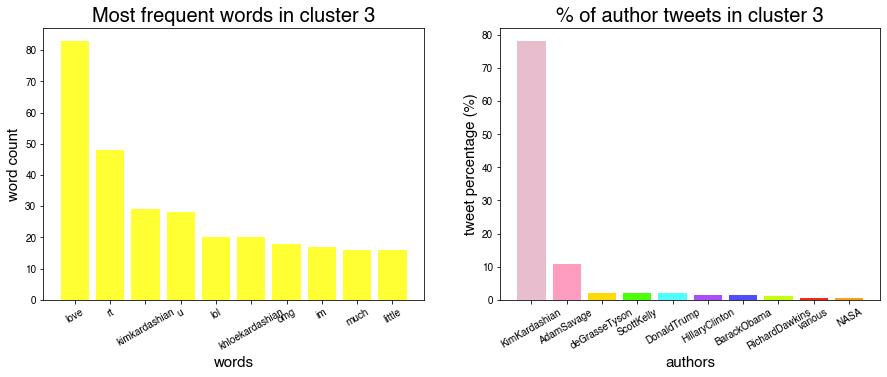

America’s businesses have created more than 14 million new private-sector jobs over 76 straight months.pic.twitter.com/e4a5X2bv0j
Most similar words to jobs: [('job', 0.7948935031890869), ('hiring', 0.6994155645370483), ('careers', 0.6679444909095764), ('assistant', 0.6661559343338013), ('manager', 0.6520527601242065), ('services', 0.636363685131073), ('healthcare', 0.6289939284324646), ('engineer', 0.6282915472984314), ('employment', 0.6218595504760742), ('business', 0.6153989434242249)]


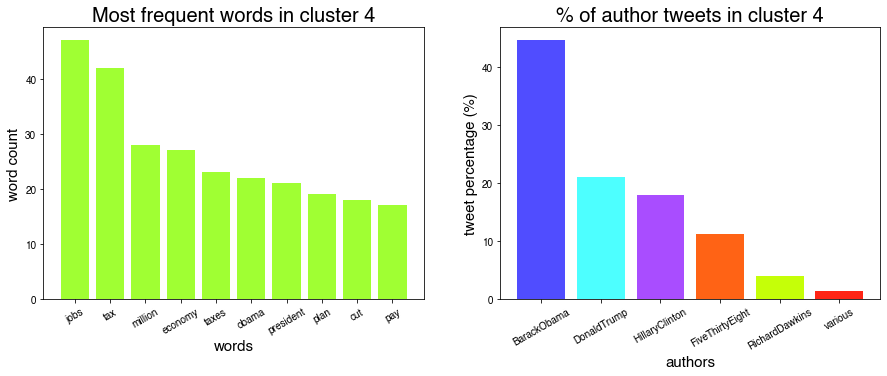

Obama: “This nation cannot succeed without a thriving middle class, and sturdy ladders for anyone hoping to get into the middle class.”
Most similar words to health: [('nutrition', 0.7356047034263611), ('healthcare', 0.7296827435493469), ('medical', 0.6970533132553101), ('benefits', 0.6768471598625183), ('education', 0.6706970930099487), ('wellness', 0.6698029041290283), ('insurance', 0.6343918442726135), ('healthy', 0.6316261291503906), ('care', 0.6277657151222229), ('safety', 0.6201788187026978)]


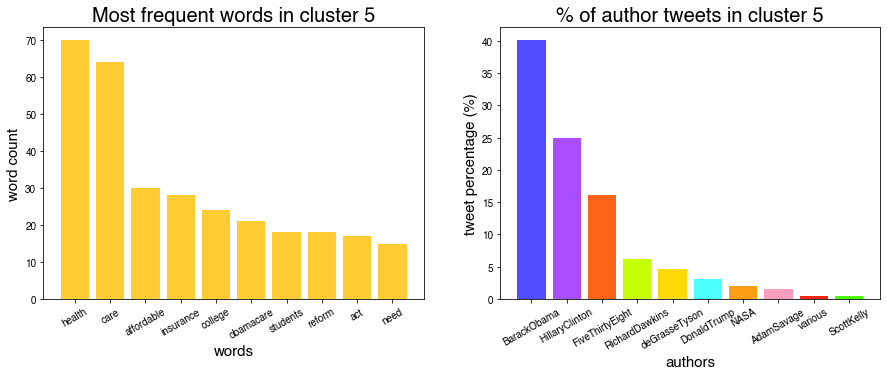

Me trying on a military-style black leather trench. I love military surplus stores! #throwbackthursday @MythBusterspic.twitter.com/OyOYdrRoPH
Most similar words to look: [('looks', 0.8735865950584412), ('like', 0.8467990159988403), ('looking', 0.8467167615890503), ('think', 0.7918827533721924), ('looked', 0.7896472811698914), ('really', 0.7871646881103516), ('pretty', 0.785760760307312), ('how', 0.7829474806785583), ('see', 0.7774219512939453), ('that', 0.7730960845947266)]


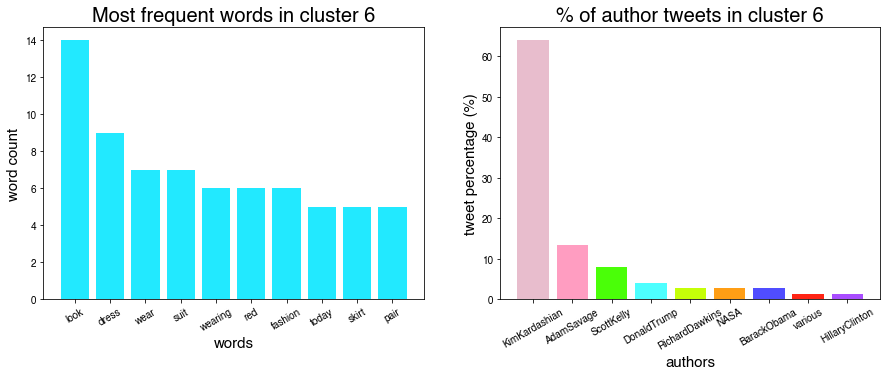

Great to meet everyone while having breakfast @ChezVachon this morning! #FITN #VoteTrumpNH
https://www.facebook.com/DonaldTrump/posts/10156616498145725:0 …pic.twitter.com/bmZvSmWe7Y
Most similar words to day: [('today', 0.8191546201705933), ('days', 0.8076238632202148), ('happy', 0.8070886135101318), ('morning', 0.7891743779182434), ('night', 0.7859731316566467), ('good', 0.7857174873352051), ('year', 0.7836430072784424), ('week', 0.7735313773155212), ('great', 0.7691963911056519), ('time', 0.766711413860321)]


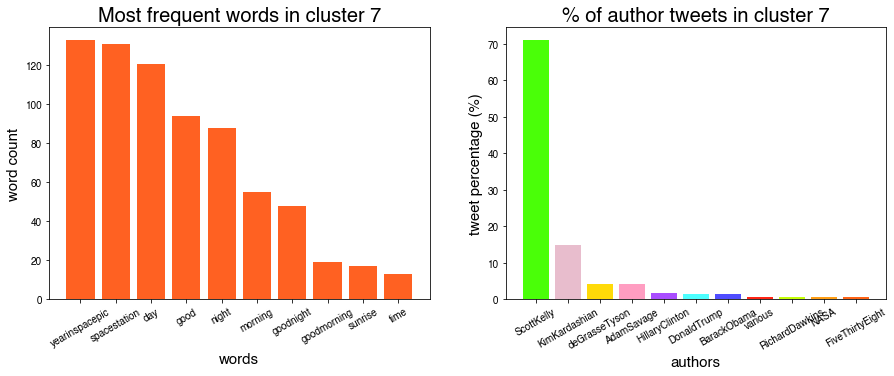

Part 4 of our epic NBA season preview takes on the best of the East: http://53eig.ht/1puPPOv pic.twitter.com/OIJNo1Uqmh
Most similar words to nba: [('lakers', 0.7727465629577637), ('lebron', 0.7391079664230347), ('playoffs', 0.7343412637710571), ('knicks', 0.7275146245956421), ('kobe', 0.7185314893722534), ('nfl', 0.7079622149467468), ('celtics', 0.6870842576026917), ('espn', 0.6822471022605896), ('all-star', 0.6797152757644653), ('basketball', 0.6748768091201782)]


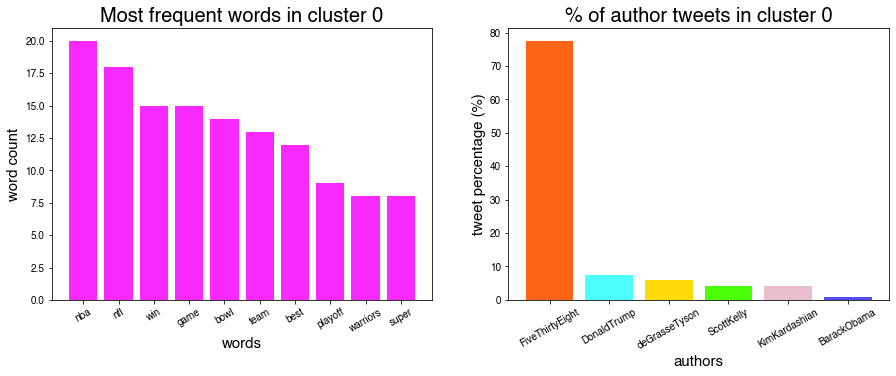

Via @Inc by @steelwire: “Donald Trump – To Micromanage or Not To Micromanage?”http://www.inc.com/drew-greenblatt/donald-trump-to-micromanage-or-not-to-micromanage.html …
Most similar words to trump: [('donald', 0.6552975177764893), ('clinton', 0.5108779072761536), ('biden', 0.5093722343444824), ('romney', 0.5069373846054077), ('warren', 0.4898340404033661), ('birther', 0.4887540340423584), ('judd', 0.4777779281139374), ('bloomberg', 0.4759959876537323), ('ivanka', 0.473548024892807), ('reid', 0.4727659225463867)]


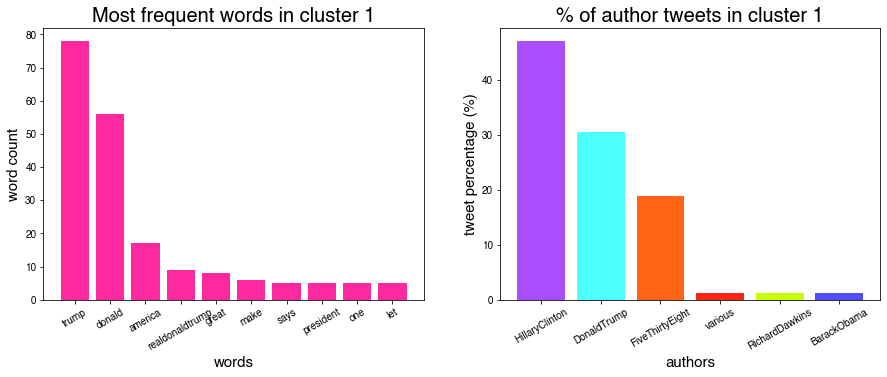

Don't forget to watch Celebrity Apprentice this Sunday night at 9 pm on NBC. You're in for a great show.http://bit.ly/6lyMkt 
Most similar words to mythbusters: [('suburgatory', 0.5084041357040405), ('x-files', 0.5044915080070496), ('portlandia', 0.4979831576347351), ('zombieland', 0.489056795835495), ('bunheads', 0.4878171682357788), ('tosh.o', 0.48016321659088135), ('frasier', 0.4567663073539734), ('hoarders', 0.4529612958431244), ('cbbc', 0.44890350103378296), ('outnumbered', 0.4470769166946411)]


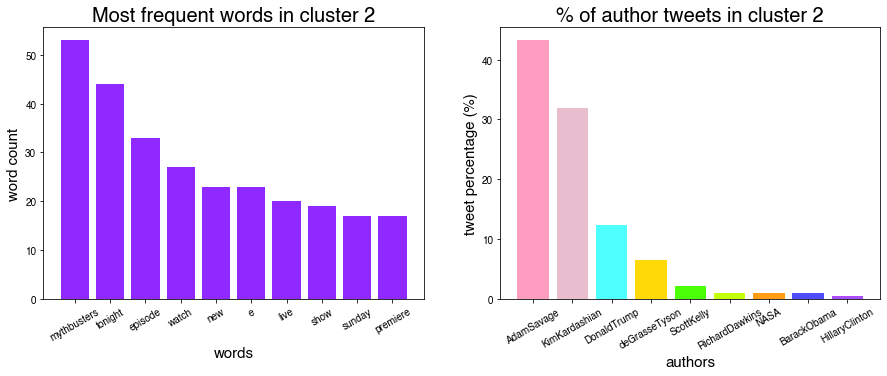

Yelp and Michelin have the same taste in restaurants: http://53eig.ht/1JHUh8G pic.twitter.com/tnXN5veowL
Most similar words to food: [('eat', 0.7688217759132385), ('lunch', 0.7405774593353271), ('eating', 0.7152000665664673), ('breakfast', 0.7140864729881287), ('dinner', 0.7139805555343628), ('meal', 0.6953850984573364), ('foods', 0.6813065409660339), ('junk', 0.6757603883743286), ('meat', 0.6753131151199341), ('yummy', 0.6666463613510132)]


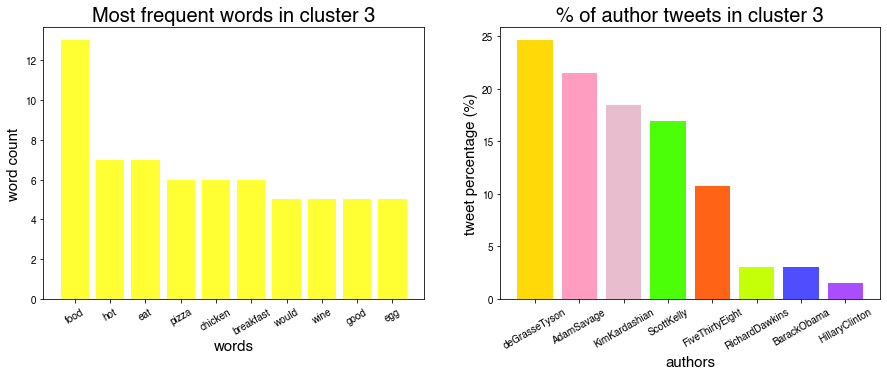

Life on Earth Arose Just Once - Tina Hesman Saey - Article - RichardDawkins.net http://bit.ly/a1Sl4u (via @rdfrs)
Most similar words to world: [('the', 0.7428237795829773), ('worl', 0.7170263528823853), ('life', 0.7134823799133301), ('most', 0.7125229239463806), ('us', 0.7046011686325073), ('of', 0.6996374130249023), ('one', 0.6992811560630798), ('earth', 0.6942176818847656), ('thing', 0.6929940581321716), ('way', 0.6921266317367554)]


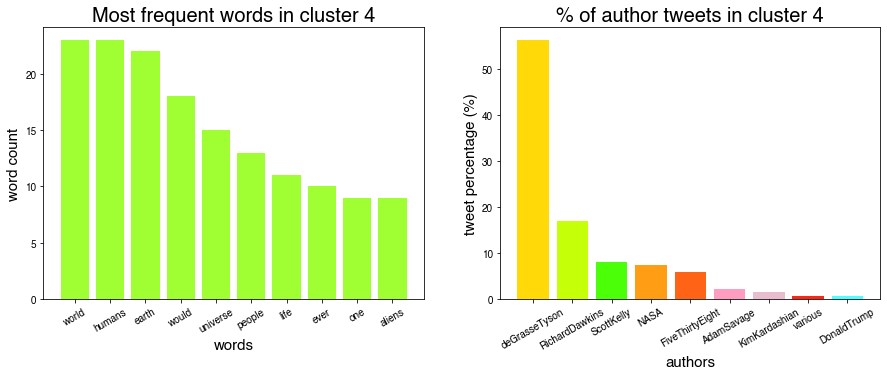

Today is President Obama's 52nd birthday. Sign his card and wish him a great one:http://OFA.BO/du4hRM 
Most similar words to happy: [('birthday', 0.8998555541038513), ('day', 0.8070886135101318), ('bday', 0.7734538316726685), ('wish', 0.7571845650672913), ('merry', 0.726503849029541), ('love', 0.7250142693519592), ('year', 0.7109401226043701), ('you', 0.7065564393997192), ('hope', 0.7004972696304321), ('thank', 0.6997926235198975)]


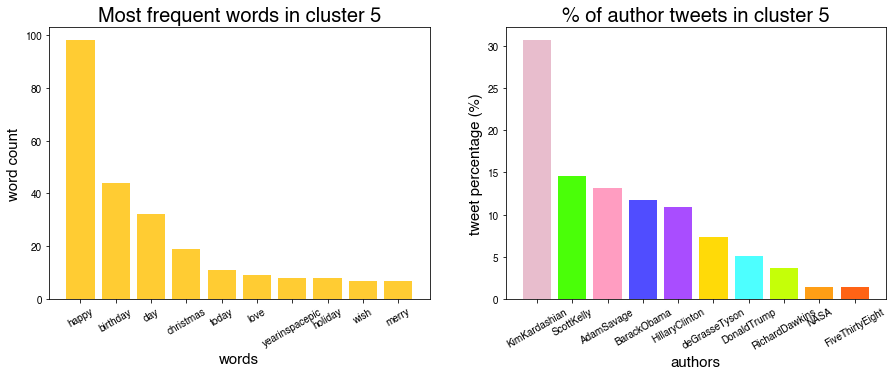

Did you know? NASA's Voyager Spacecraft is 16 hrs 37 mins 11 secs of light-travel time from Earth!http://go.nasa.gov/yvdrQU 
Most similar words to year: [('years', 0.8752752542495728), ('next', 0.8064093589782715), ('month', 0.8049964308738708), ('days', 0.8016144633293152), ('last', 0.7985324859619141), ('first', 0.7958666086196899), ('week', 0.7941757440567017), ('day', 0.7836428880691528), ('months', 0.7811575531959534), ('since', 0.7721916437149048)]


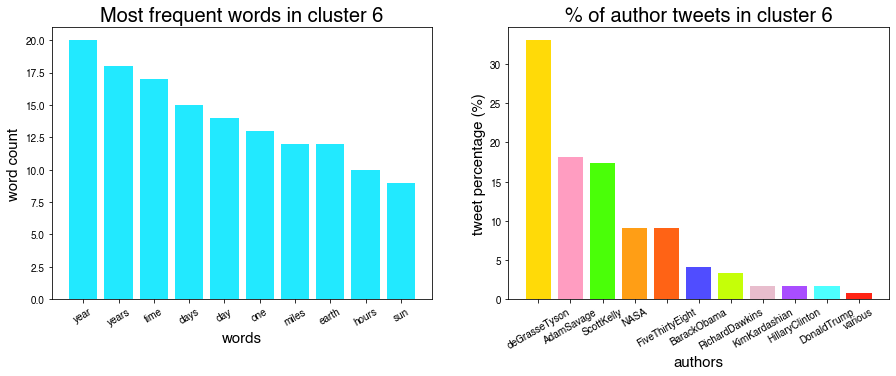

'End-of-Days Danger' by Lawrence Krauss - Scientific American - RichardDawkins.net http://bit.ly/bt5s53
Most similar words to richard: [('john', 0.683191180229187), ('stephen', 0.679672360420227), ('martin', 0.6764752864837646), ('sherman', 0.6711413860321045), ('andrew', 0.6660736799240112), ('robert', 0.6609762907028198), ('charles', 0.6474153995513916), ('brian', 0.6445379257202148), ('wilson', 0.6405532360076904), ('david', 0.6404967904090881)]


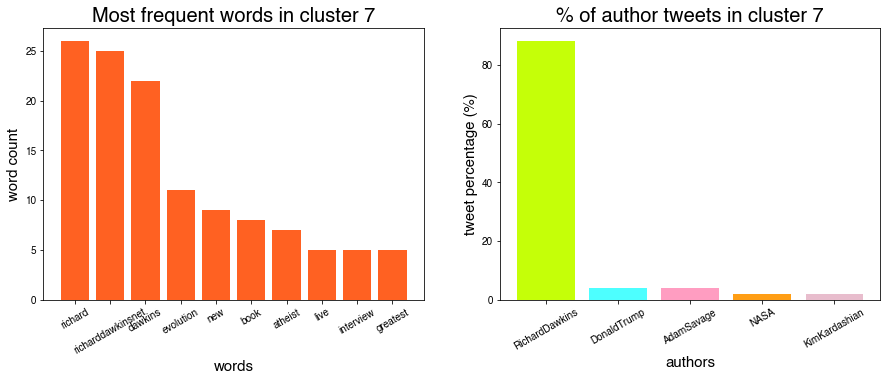

IndexError: list index out of range

In [ ]:
# Let's look at dbSCan now

# Let's do this for all dbscan clusters

for i in range(num_clusters):
    clust_words, clust_authors,sample_tweets = cluster_metrics(i,tsne_db,tweets,authors)
#     print(clust_words[:10])
#     print(clust_authors)
    print(sample_tweets[0])
    vis_metrics(clust_words[:10],clust_authors,i%8)


## Great, dbscan does seem to do a better job at detecting true clusters, a lot of noise means things can't be classified clustered though, that's a tradeoff

found some clusters relating to food, tv stuff, etc.


## Now let's use PCA to see what we can get


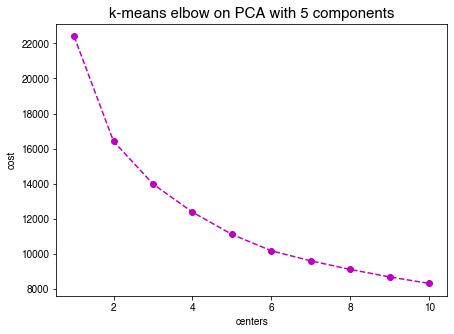

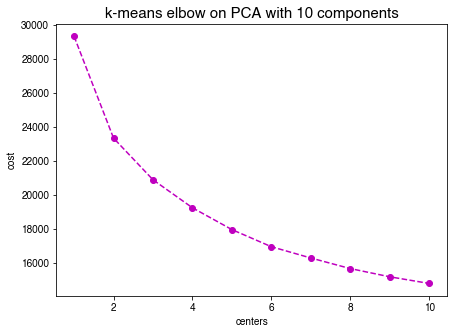

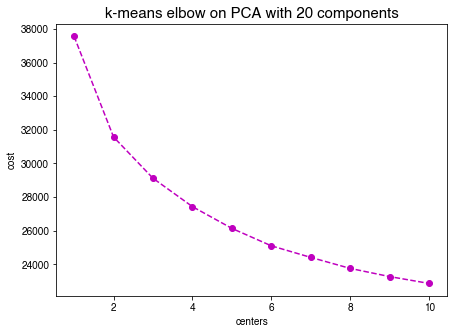

In [ ]:
# pca_coords_2 = PCA(n_components=2).fit_transform(X_200)
# pca_coords_5 = PCA(n_components=5).fit_transform(X_200)
# pca_coords_10 = PCA(n_components=10).fit_transform(X_200)
# pca_coords_20 = PCA(n_components=20).fit_transform(X_200)

# Let's do k-means elbow on PCA

kmCost(pca_coords_5,5,'PCA')
kmCost(pca_coords_10,10,'PCA')
kmCost(pca_coords_20,20,'PCA')



## Definitely doesn't look to be as elbow-y as t-sne here. 

I'll do 6-8 on 10 components

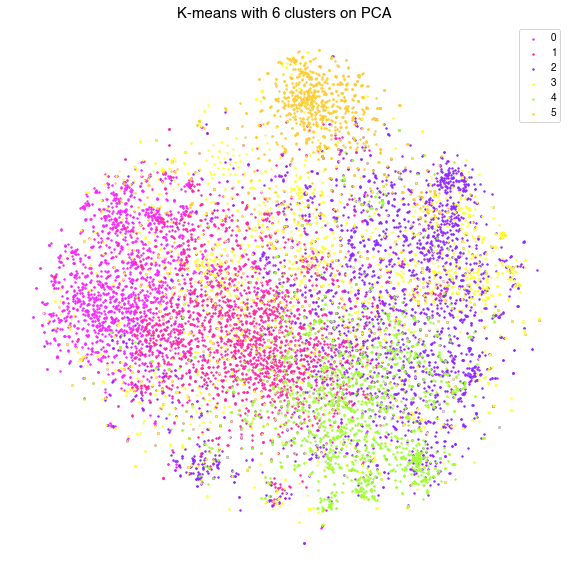

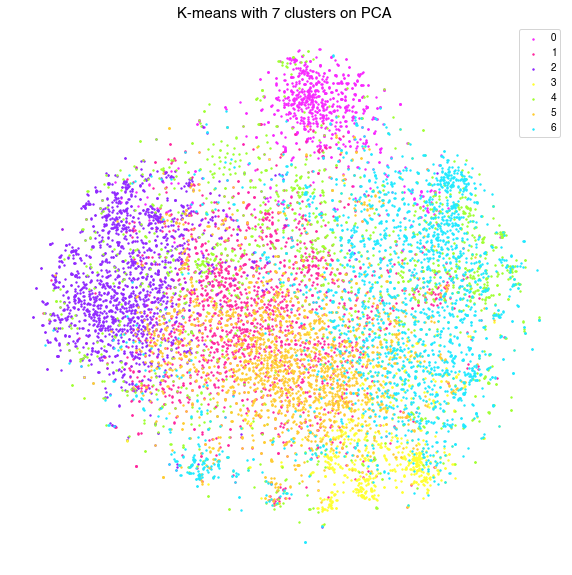

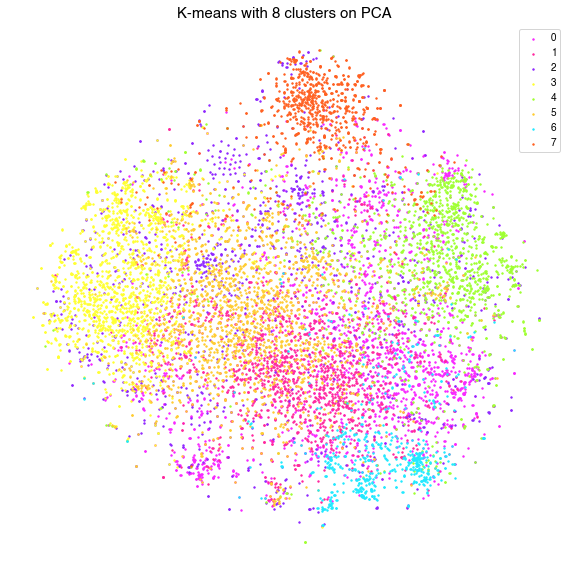

In [ ]:
# def kMeansPlotSingle(proj_data,clust_data,clusters,n_components,dim_reduct,title=None): 
kMeansPlotSingle(tsne_coords_200_cos,pca_coords_10,6,10,'PCA')
kMeansPlotSingle(tsne_coords_200_cos,pca_coords_10,7,10,'PCA')
kMeansPlotSingle(tsne_coords_200_cos,pca_coords_10,8,10,'PCA')

[ 0 -1 -1 ... -1 -1 -1]
number of clusters:  5


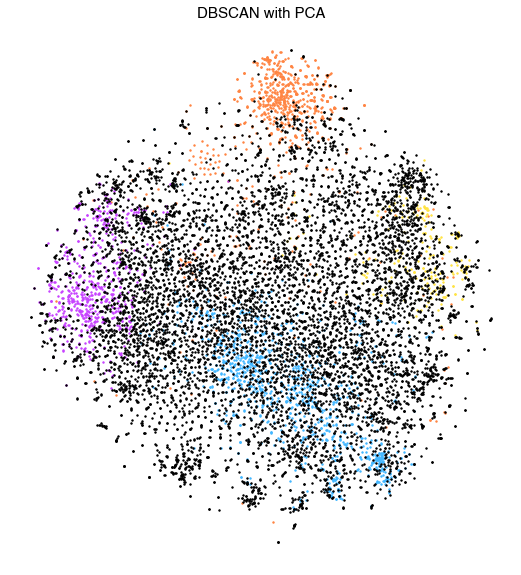

In [ ]:
# DBSCAN

PCA_db = DBSCAN(eps=0.088,min_samples=50,metric='cosine').fit_predict(pca_coords_10)
# tsne_db = DBSCAN(eps=2.5,min_samples=50).fit_predict(X_tsne_3)
print(PCA_db)
num_clusters = len(np.unique(PCA_db))
print("number of clusters: ",num_clusters)


plt.figure(figsize = (20,10))
colors = ['#ff8543','#43b7ff','#c743ff','#ffe343','#50ff2d','#79fff8','#ff0084','#9c7bff'];
plt.subplot(1,2,1)
for i in range(num_clusters):
    i_color = i % 8
    plt.scatter(tsne_coords_200_cos[PCA_db == i, 0],tsne_coords_200_cos[PCA_db == i, 1],c=colors[i_color],s=2)
plt.scatter(tsne_coords_200_cos[PCA_db == -1, 0],tsne_coords_200_cos[PCA_db == -1, 1],c="black",s=2)
        

plt.title("DBSCAN with PCA",fontsize=15)
plt.axis("off")
[i.set_linewidth(0.4) for i in plt.gca().spines.values()]
plt.show()
    

In [ ]:
# SAving stuff:


# save tsne coords and clusterings

pca_k6 = clusterOut(pca_coords_10,6)
pca_k7 = clusterOut(pca_coords_10,7)
pca_k8 = clusterOut(pca_coords_10,8)


# # Save as numpy format
np.save('./pca_coords_10',pca_coords_10)

np.save('./pca_k6',pca_k6)
np.save('./pca_k7',pca_k7)
np.save('./pca_k8',pca_k8)
np.save('./pca_db',PCA_db)

photo shoot glam...very Sophia Loren http://twitpic.com/6szwuo 
Most similar words to new: [('this', 0.7495081424713135), ('my', 0.7429271936416626), ('the', 0.7404195666313171), ('first', 0.7356249094009399), ("'s", 0.7235701084136963), ('next', 0.7227763533592224), ('latest', 0.7155960202217102), ('another', 0.7103580832481384), ('for', 0.7102584838867188), ('from', 0.7099617123603821)]


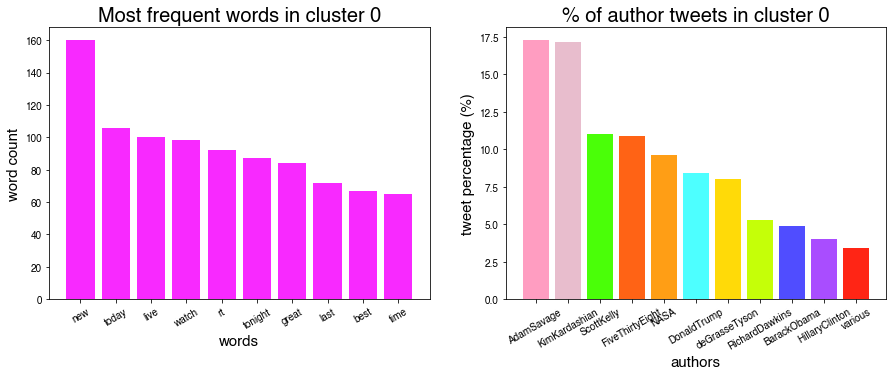

If house cats were in charge, I wonder if they would post videos of cute humans doing stupid things.
Most similar words to get: [('getting', 0.884138286113739), ('got', 0.8624414205551147), ('need', 0.8388120532035828), ("n't", 0.8386625647544861), ('out', 0.8256463408470154), ('when', 0.8241853713989258), ('it', 0.8206652402877808), ('have', 0.8198903799057007), ('that', 0.818397045135498), ('should', 0.8171700835227966)]


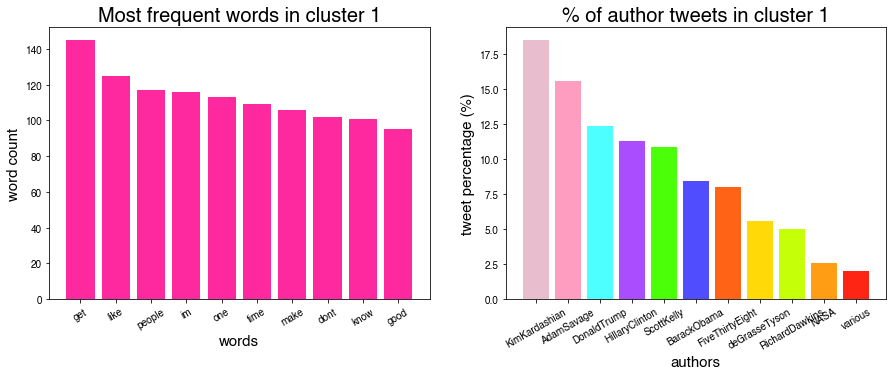

“Goyim” not offensive? In that case what IS offensive is teaching children that what the nazis did is what “goyim” dohttp://www.independent.co.uk/news/education/education-news/threeyearold-ultraorthodox-jewish-children-told-the-nonjews-are-evil-in-worksheet-produced-by-school-10481682.html …
Most similar words to trump: [('donald', 0.6552975177764893), ('clinton', 0.5108779072761536), ('biden', 0.5093722343444824), ('romney', 0.5069373846054077), ('warren', 0.4898340404033661), ('birther', 0.4887540340423584), ('judd', 0.4777779281139374), ('bloomberg', 0.4759959876537323), ('ivanka', 0.473548024892807), ('reid', 0.4727659225463867)]


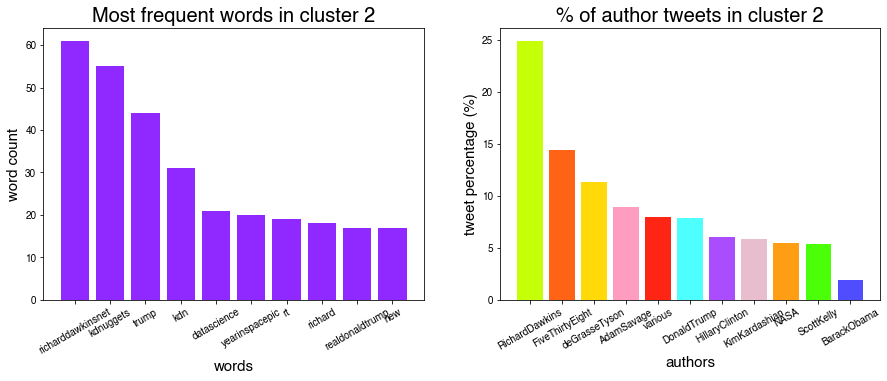

Committing to vote on Facebook is a simple act that could reach thousands of key voters by Tuesday’s elections. http://OFA.BO/W8aqfp
Most similar words to president: [('obama', 0.792696475982666), ('barack', 0.7790480256080627), ('prez', 0.7003239393234253), ('clinton', 0.6973133087158203), ('government', 0.6662343740463257), ('romney', 0.6630515456199646), ('presidential', 0.6599113941192627), ('potus', 0.6554629802703857), ('pres.', 0.6550410985946655), ('elected', 0.6529227495193481)]


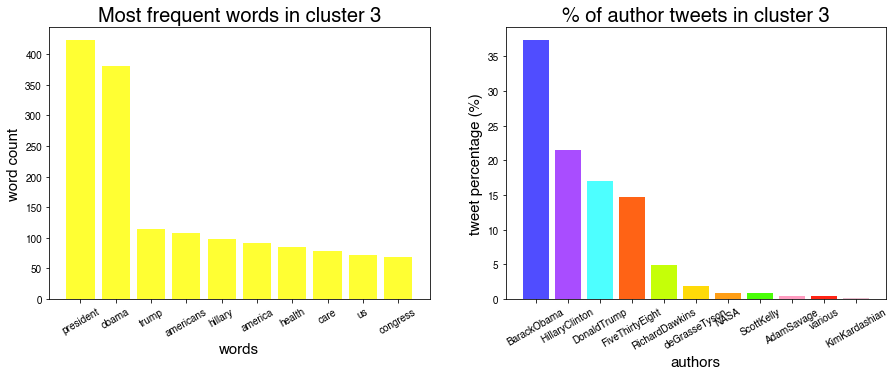

Three people have begun a return to Earth from space. Watch landing from 8:30amET/12:30 UTC at http://www.nasa.gov/nasatv pic.twitter.com/KeoLbzGEFf
Most similar words to space: [('earth', 0.6140348315238953), ('inside', 0.5923542976379395), ('planet', 0.5918987989425659), ('room', 0.5893489122390747), ('the', 0.5725523233413696), ('there', 0.567142128944397), ('into', 0.563407838344574), ('alien', 0.5586540699005127), ('shuttle', 0.5558466911315918), ('view', 0.554189920425415)]


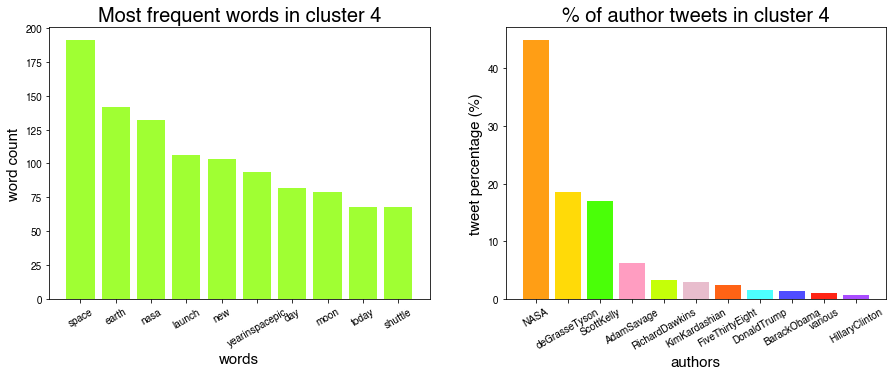

Selective memory - @BarackObama says that he "forgets" the recession http://bit.ly/IYtzM7  Maybe that's why he is forgetting to create jobs.
Most similar words to people: [('ppl', 0.8408032059669495), ('other', 0.827694833278656), ('when', 0.8214244246482849), ('they', 0.8209879994392395), ("n't", 0.8185396790504456), ('many', 0.817920446395874), ('think', 0.8060885667800903), ('them', 0.8057222366333008), ('everyone', 0.8016465306282043), ('know', 0.8015024662017822)]


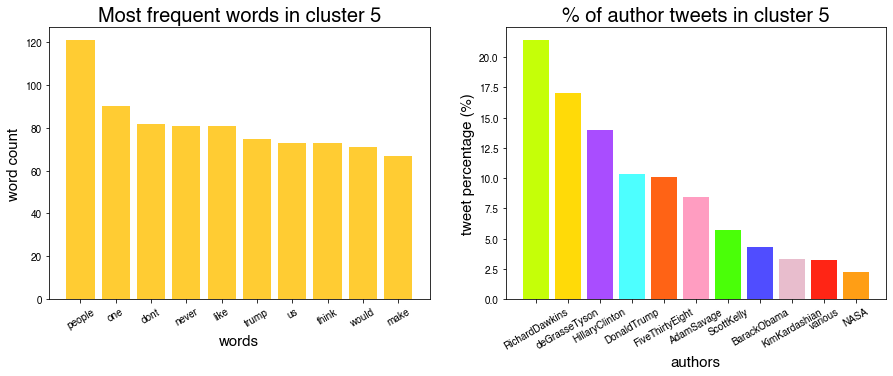

Good morning New York. I've been back & forth from LA to NYC 3 times in one week. Tiiiiredddd
Most similar words to day: [('today', 0.8191546201705933), ('days', 0.8076238632202148), ('happy', 0.8070886135101318), ('morning', 0.7891743779182434), ('night', 0.7859731316566467), ('good', 0.7857174873352051), ('year', 0.7836430072784424), ('week', 0.7735313773155212), ('great', 0.7691963911056519), ('time', 0.766711413860321)]


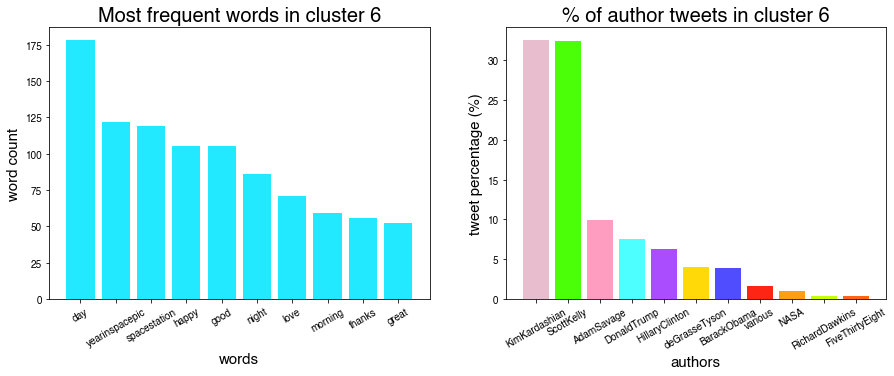

Overview of #Python Visualization Tools #KDN http://ow.ly/YX5xy  via @KDnuggets
Most similar words to via: [('<url>', 0.7011606097221375), ('vía', 0.6613482236862183), ('blog', 0.6338077783584595), ('|', 0.6313736438751221), ('by', 0.6141097545623779), ('news', 0.6133575439453125), ('video', 0.5988732576370239), ('youtube', 0.5907558798789978), ('post', 0.5865345597267151), ('check', 0.584824800491333)]


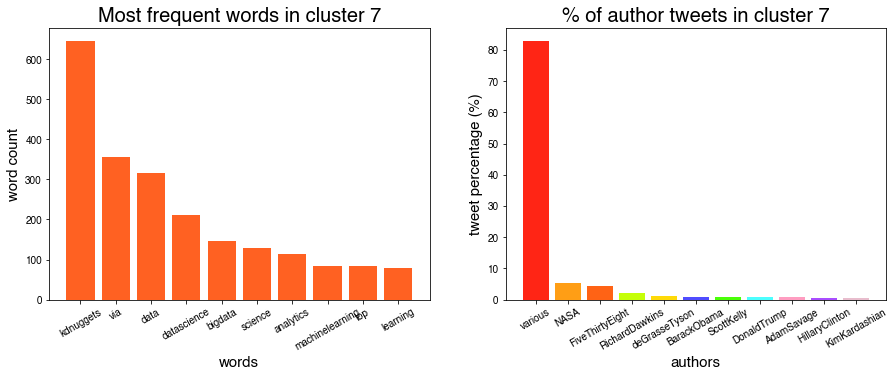

In [ ]:
## Exploring PCA clusters - kmeans

# Let's do this for all 8 clusters

for i in range(8):
    clust_words, clust_authors,sample_tweets = cluster_metrics(i,pca_k8,tweets,authors)
#     print(clust_words[:10])
#     print(clust_authors)
    print(sample_tweets[0])
    vis_metrics(clust_words[:10],clust_authors,i)

Selective memory - @BarackObama says that he "forgets" the recession http://bit.ly/IYtzM7  Maybe that's why he is forgetting to create jobs.
Most similar words to president: [('obama', 0.792696475982666), ('barack', 0.7790480256080627), ('prez', 0.7003239393234253), ('clinton', 0.6973133087158203), ('government', 0.6662343740463257), ('romney', 0.6630515456199646), ('presidential', 0.6599113941192627), ('potus', 0.6554629802703857), ('pres.', 0.6550410985946655), ('elected', 0.6529227495193481)]


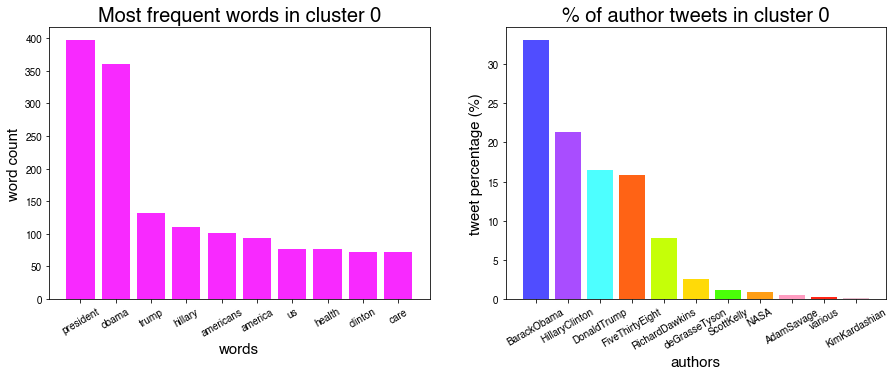

If house cats were in charge, I wonder if they would post videos of cute humans doing stupid things.
Most similar words to people: [('ppl', 0.8408032059669495), ('other', 0.827694833278656), ('when', 0.8214244246482849), ('they', 0.8209879994392395), ("n't", 0.8185396790504456), ('many', 0.817920446395874), ('think', 0.8060885667800903), ('them', 0.8057222366333008), ('everyone', 0.8016465306282043), ('know', 0.8015024662017822)]


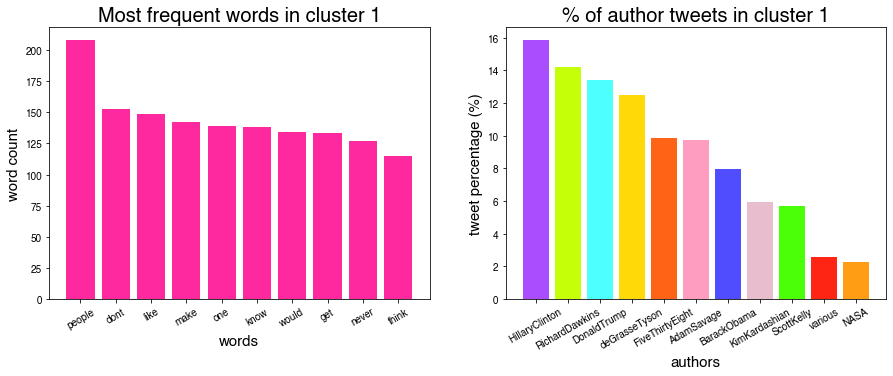

Three people have begun a return to Earth from space. Watch landing from 8:30amET/12:30 UTC at http://www.nasa.gov/nasatv pic.twitter.com/KeoLbzGEFf
Most similar words to new: [('this', 0.7495081424713135), ('my', 0.7429271936416626), ('the', 0.7404195666313171), ('first', 0.7356249094009399), ("'s", 0.7235701084136963), ('next', 0.7227763533592224), ('latest', 0.7155960202217102), ('another', 0.7103580832481384), ('for', 0.7102584838867188), ('from', 0.7099617123603821)]


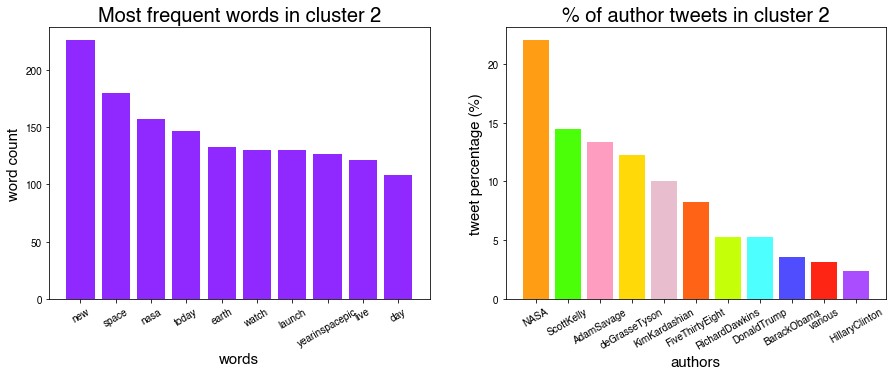

“Goyim” not offensive? In that case what IS offensive is teaching children that what the nazis did is what “goyim” dohttp://www.independent.co.uk/news/education/education-news/threeyearold-ultraorthodox-jewish-children-told-the-nonjews-are-evil-in-worksheet-produced-by-school-10481682.html …
Most similar words to space: [('earth', 0.6140348315238953), ('inside', 0.5923542976379395), ('planet', 0.5918987989425659), ('room', 0.5893489122390747), ('the', 0.5725523233413696), ('there', 0.567142128944397), ('into', 0.563407838344574), ('alien', 0.5586540699005127), ('shuttle', 0.5558466911315918), ('view', 0.554189920425415)]


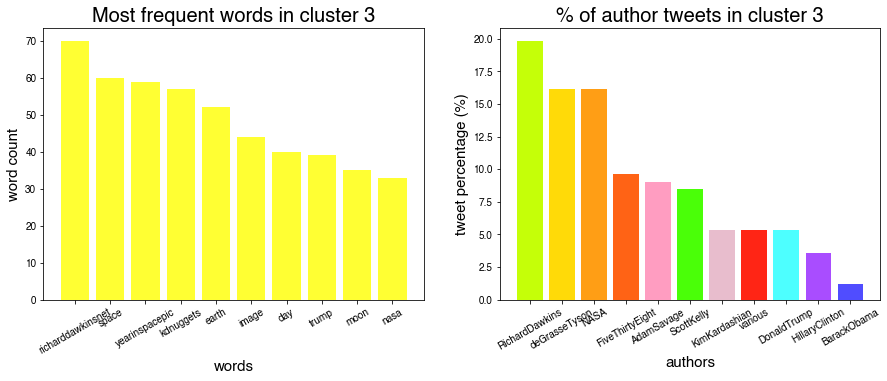

Breakfast with my friend @Cmdr_Hadfield yesterday morning. Dammit, he looks better in my cowboy hat than I do.pic.twitter.com/52g6Fdmzee
Most similar words to day: [('today', 0.8191546201705933), ('days', 0.8076238632202148), ('happy', 0.8070886135101318), ('morning', 0.7891743779182434), ('night', 0.7859731316566467), ('good', 0.7857174873352051), ('year', 0.7836430072784424), ('week', 0.7735313773155212), ('great', 0.7691963911056519), ('time', 0.766711413860321)]


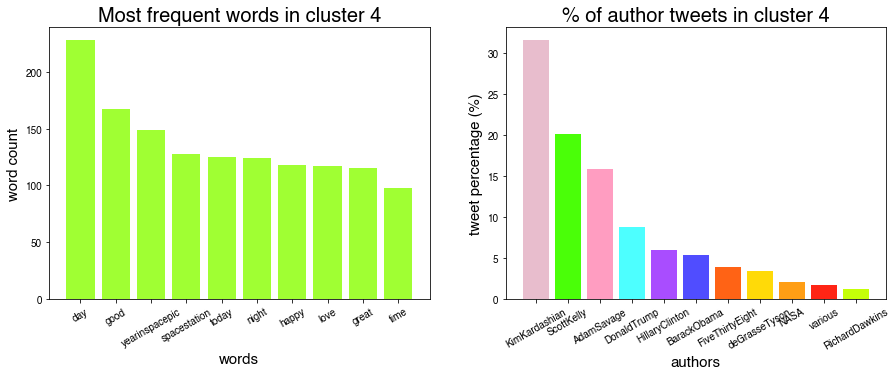

Overview of #Python Visualization Tools #KDN http://ow.ly/YX5xy  via @KDnuggets
Most similar words to via: [('<url>', 0.7011606097221375), ('vía', 0.6613482236862183), ('blog', 0.6338077783584595), ('|', 0.6313736438751221), ('by', 0.6141097545623779), ('news', 0.6133575439453125), ('video', 0.5988732576370239), ('youtube', 0.5907558798789978), ('post', 0.5865345597267151), ('check', 0.584824800491333)]


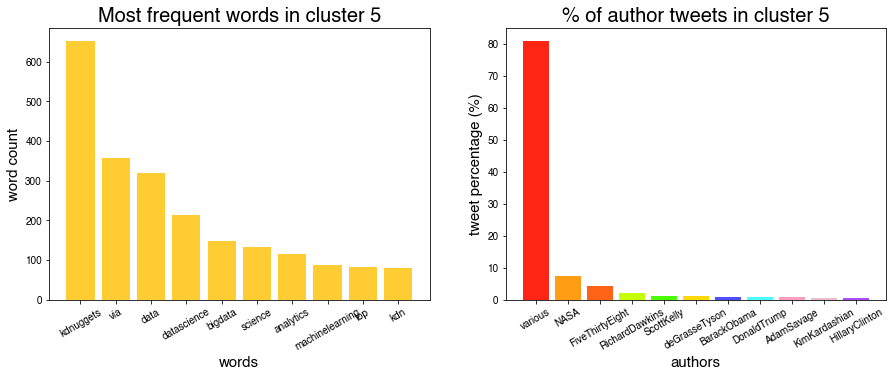

In [ ]:
# Looks look at k=6 to compare with t-sne

## Exploring PCA clusters - kmeans

# Let's do this for all 8 clusters

for i in range(6):
    clust_words, clust_authors,sample_tweets = cluster_metrics(i,pca_k6,tweets,authors)
#     print(clust_words[:10])
#     print(clust_authors)
    print(sample_tweets[0])
    vis_metrics(clust_words[:10],clust_authors,i)

“Goyim” not offensive? In that case what IS offensive is teaching children that what the nazis did is what “goyim” dohttp://www.independent.co.uk/news/education/education-news/threeyearold-ultraorthodox-jewish-children-told-the-nonjews-are-evil-in-worksheet-produced-by-school-10481682.html …
Most similar words to via: [('<url>', 0.7011606097221375), ('vía', 0.6613482236862183), ('blog', 0.6338077783584595), ('|', 0.6313736438751221), ('by', 0.6141097545623779), ('news', 0.6133575439453125), ('video', 0.5988732576370239), ('youtube', 0.5907558798789978), ('post', 0.5865345597267151), ('check', 0.584824800491333)]


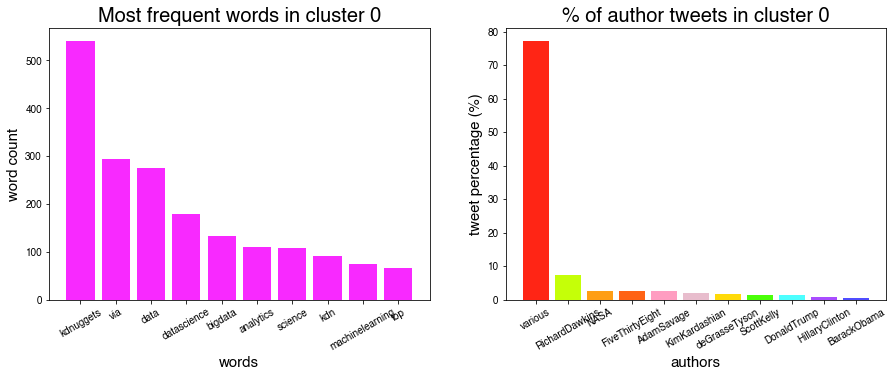

If house cats were in charge, I wonder if they would post videos of cute humans doing stupid things.
Most similar words to day: [('today', 0.8191546201705933), ('days', 0.8076238632202148), ('happy', 0.8070886135101318), ('morning', 0.7891743779182434), ('night', 0.7859731316566467), ('good', 0.7857174873352051), ('year', 0.7836430072784424), ('week', 0.7735313773155212), ('great', 0.7691963911056519), ('time', 0.766711413860321)]


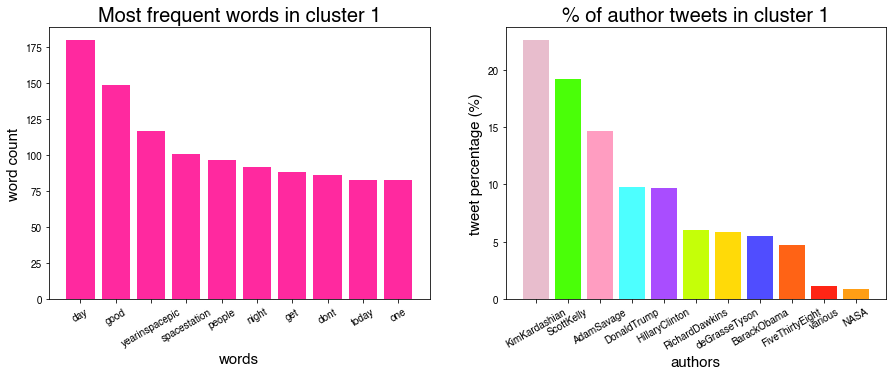

The United States presidency requires steadiness as well as strength and smarts.

Donald Trump is not qualified.https://amp.twimg.com/v/d68ab331-934e-408e-8e4b-bb5df97c6a0f …
Most similar words to president: [('obama', 0.792696475982666), ('barack', 0.7790480256080627), ('prez', 0.7003239393234253), ('clinton', 0.6973133087158203), ('government', 0.6662343740463257), ('romney', 0.6630515456199646), ('presidential', 0.6599113941192627), ('potus', 0.6554629802703857), ('pres.', 0.6550410985946655), ('elected', 0.6529227495193481)]


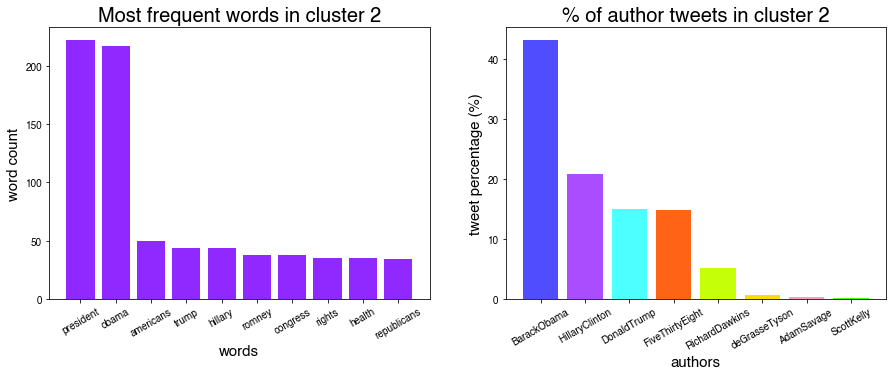

Will the Perseids be visible from {insert your location}? NASA's meteor scientist helps you figure it out at http://go.usa.gov/cB2
Most similar words to space: [('earth', 0.6140348315238953), ('inside', 0.5923542976379395), ('planet', 0.5918987989425659), ('room', 0.5893489122390747), ('the', 0.5725523233413696), ('there', 0.567142128944397), ('into', 0.563407838344574), ('alien', 0.5586540699005127), ('shuttle', 0.5558466911315918), ('view', 0.554189920425415)]


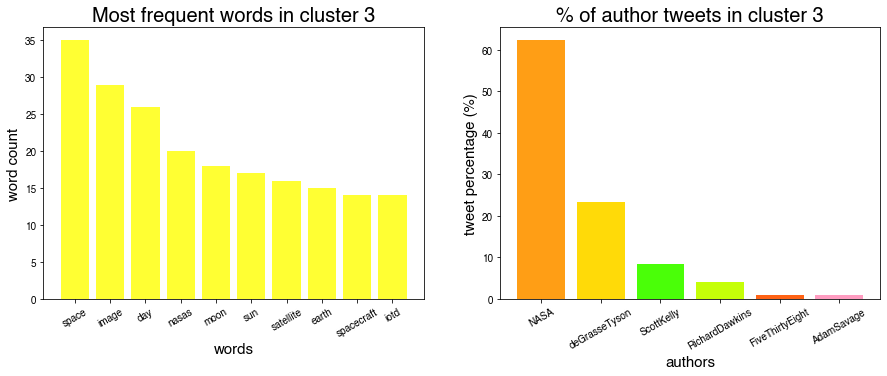

IndexError: list index out of range

In [ ]:
# Now let's explore dbscan

# Let's do this for all dbscan clusters

for i in range(num_clusters):
    clust_words, clust_authors,sample_tweets = cluster_metrics(i,PCA_db,tweets,authors)
#     print(clust_words[:10])
#     print(clust_authors)
    print(sample_tweets[0])
    vis_metrics(clust_words[:10],clust_authors,i%8)
